In [2]:
import sys
sys.path.append("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/")

In [3]:
import os
import pandas as pd
import numpy as np
import joblib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mplfooty.pitch import Pitch
from viz.afl_colours import team_colours

from vaep.domain.vaep.vaep import *
from vaep.domain.vaep.chain_visualisations import *

import warnings
warnings.filterwarnings('ignore')

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

%load_ext autoreload
%autoreload 2

In [4]:
font_path = "/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/fonts"
for x in os.listdir(font_path):
    if x != ".DS_Store":
        for y in os.listdir(f"{font_path}/{x}"):
            if y.split(".")[-1] == "ttf":
                fm.fontManager.addfont(f"{font_path}/{x}/{y}")
                try:
                    fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y.split("-")[0])
                except Exception:
                    continue

In [5]:
plt.style.use("/Users/ciaran/Documents/Projects/AFL/git-repositories/afl-player-ratings/viz/mplstyle/dark_theme.mplstyle")

Load VAEP Data

In [6]:
chain_data = pd.read_csv("/Users/ciaran/Documents/Projects/AFL/data/scored_match_chains_v2.csv")
chain_data.head()

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,ReceiverTeam,Receiver,xT_created,xT_denied,match_id,chain_number,order,overall_seconds,start_x,start_y,end_x,end_y,action_type,outcome_type,scores,concedes,offensive_value,defensive_value,vaep_value,xScore,exp_scores,exp_concedes,exp_offensive_value,exp_defensive_value,exp_vaep_value
0,1,centreBounce,goal,1.0,1,13,13.0,Brisbane Lions,NaN,NaN,NaN,Centre Bounce,0.0,0.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,centreBounce,goal,2.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Hard Ball Get,8.0,-5.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Brisbane Lions,Dayne Zorko,0.005595,NaN,202101_BrisbaneLions_Sydney,1.0,2.0,24.0,8.0,-5.0,9.0,-6.0,Hard Ball Get,effective,0.059166,0.004202,0.000000,-0.000000,0.000000,NaN,0.432347,0.120213,0.000000,-0.00000,0.000000
2,1,centreBounce,goal,3.0,1,13,24.0,Brisbane Lions,Brisbane Lions,Dayne Zorko,Dayne_Zorko,Handball,9.0,-6.0,ineffective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,NaN,0.0,202101_BrisbaneLions_Sydney,1.0,3.0,24.0,9.0,-6.0,-11.0,7.0,Handball,ineffective,0.013482,0.020271,-0.045684,-0.016070,-0.061754,NaN,0.036775,0.315053,-0.395572,-0.19484,-0.590412
3,1,centreBounce,goal,4.0,1,13,28.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Loose Ball Get,11.0,-7.0,NaN,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,Oliver Florent,0.000000,NaN,202101_BrisbaneLions_Sydney,1.0,4.0,28.0,-11.0,7.0,-12.0,5.0,Loose Ball Get,effective,0.041042,0.016021,0.020770,-0.002539,0.018231,NaN,0.812755,0.140635,0.497702,-0.10386,0.393842
4,1,centreBounce,goal,5.0,1,13,29.0,Brisbane Lions,Sydney,Oliver Florent,Oliver_Florent,Handball,12.0,-5.0,effective,NaN,NaN,138,156,Brisbane Lions,Sydney,right,202101_BrisbaneLions_Sydney,202101,2021.0,NaN,Sydney,George Hewett,0.007561,NaN,202101_BrisbaneLions_Sydney,1.0,5.0,29.0,-12.0,5.0,-14.0,2.0,Handball,effective,0.028680,0.018624,-0.012362,-0.002603,-0.014965,NaN,0.942599,0.140635,0.129844,-0.00000,0.129844


Plotting Chains with VAEP Values

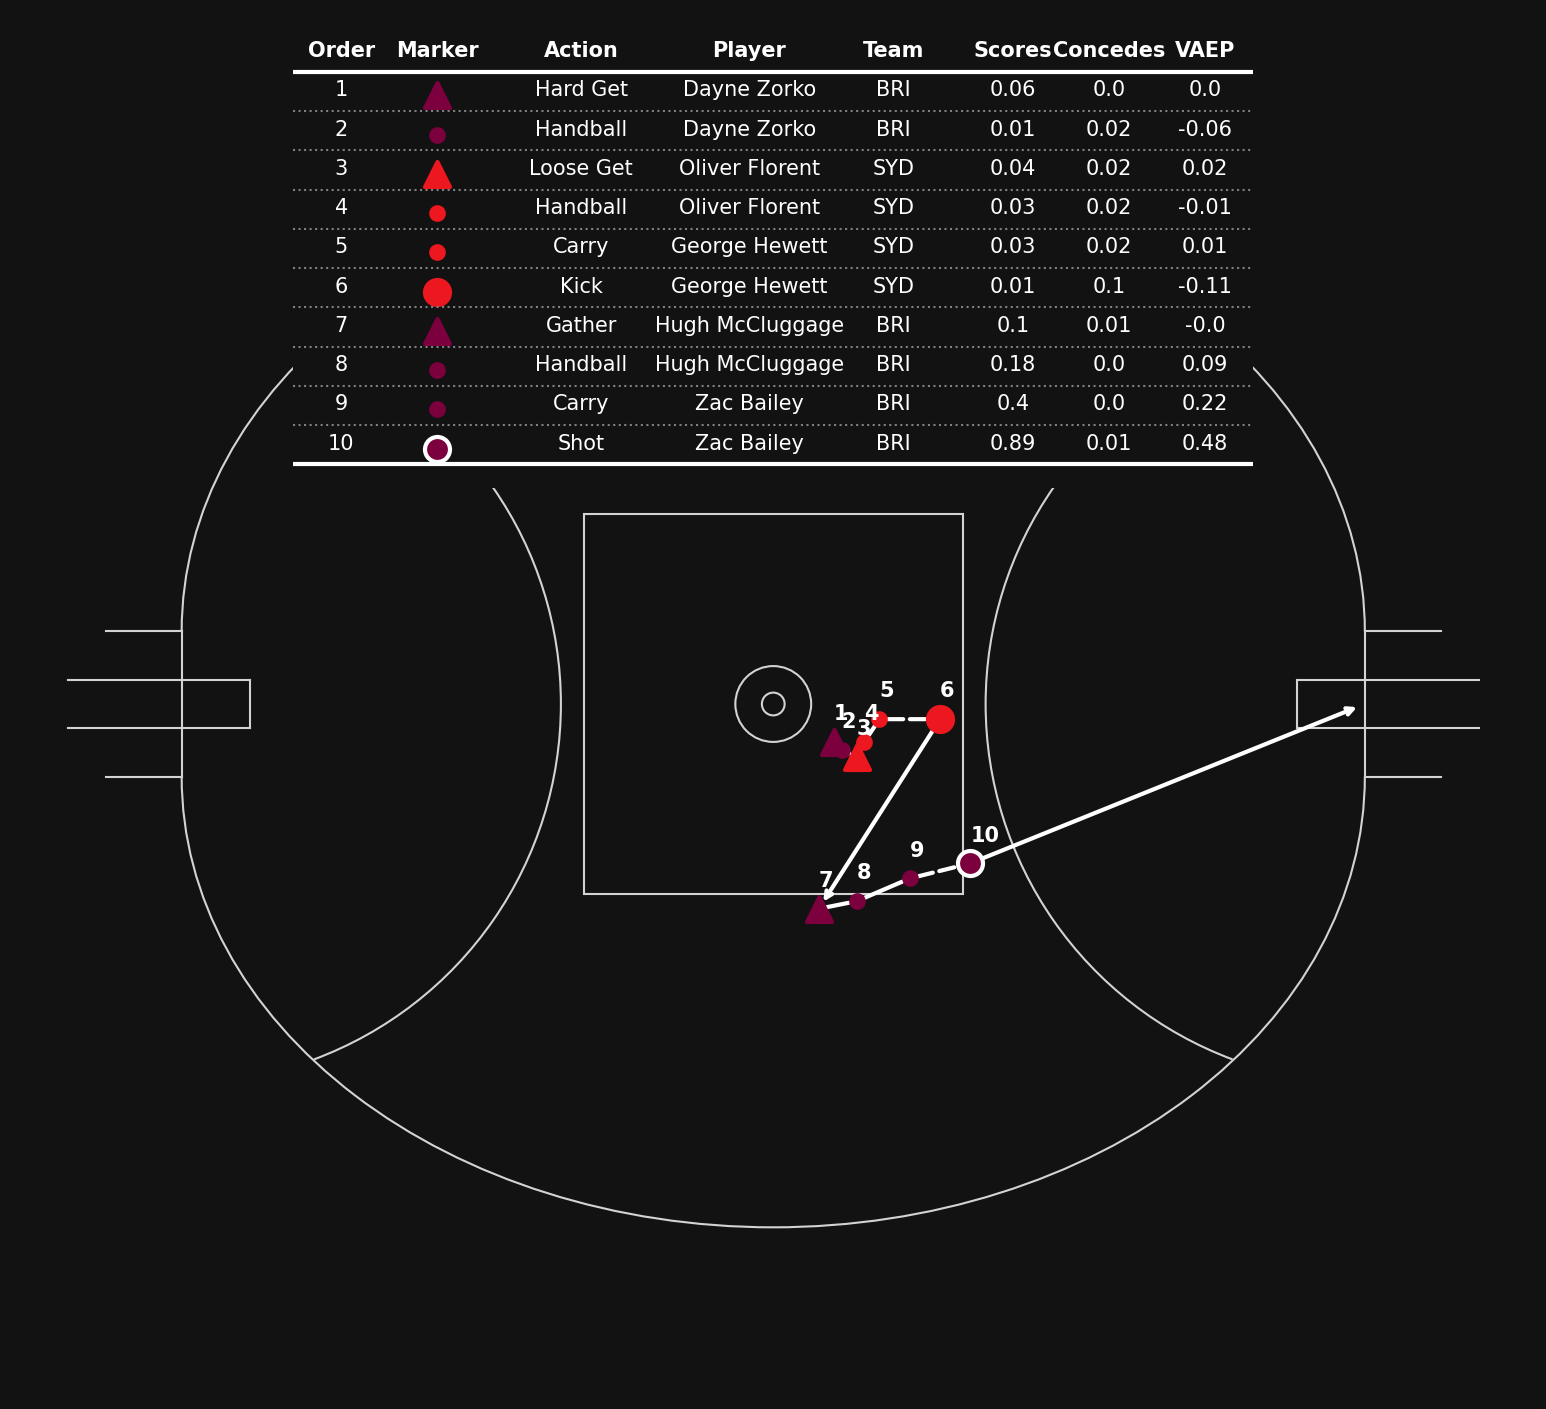

In [12]:
match_id = "202101_BrisbaneLions_Sydney"
chain_number = 1
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

In [20]:
chain = get_chain(chain_data, top_vaep_matches[1], top_vaep_chain_numbers[1])
chain

,Chain_Number,Initial_State,Final_State,Order,Quarter,Quarter_Duration_Chain_Start,Quarter_Duration,Team_Chain,Team,Player,AFL_API_Player_ID,Description,x,y,Disposal,Shot_At_Goal,Behind_Detail,Venue_Width,Venue_Length,Home_Team,Away_Team,Home_Team_Direction_Q1,Match_ID,Round_ID,Year,Season,ReceiverTeam,Receiver,xT_created,xT_denied,match_id,chain_number,order,overall_seconds,start_x,start_y,end_x,end_y,action_type,outcome_type,scores,concedes,offensive_value,defensive_value,vaep_value,xScore,exp_scores,exp_concedes,exp_offensive_value,exp_defensive_value,exp_vaep_value
858385,75,possGain,goal,545.0,2,60,60.0,Brisbane Lions,Brisbane Lions,Harris Andrews,Harris_Andrews,Free For,-59.0,-12.0,NaN,NaN,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,Brisbane Lions,Harris Andrews,-0.003886,NaN,202301_PortAdelaide_BrisbaneLions,75.0,545.0,2014.0,-59.0,-12.0,-59.0,-14.0,Free For,effective,0.017224,0.029823,0.011190,0.126238,0.137428,NaN,0.357903,0.269873,0.288398,0.583658,0.872056
858386,75,possGain,goal,546.0,2,60,61.0,Brisbane Lions,Brisbane Lions,Harris Andrews,Harris_Andrews,Handball,-59.0,-14.0,effective,NaN,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,Brisbane Lions,Daniel Rich,-0.000746,NaN,202301_PortAdelaide_BrisbaneLions,75.0,546.0,2015.0,-59.0,-14.0,-60.0,-19.0,Handball,effective,0.021615,0.042488,0.004392,-0.012665,-0.008273,NaN,0.299745,0.302035,-0.058157,-0.032162,-0.090319
858387,75,possGain,goal,547.0,2,60,63.0,Brisbane Lions,Brisbane Lions,Daniel Rich,Daniel_Rich,Handball Received,-60.0,-19.0,NaN,NaN,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,Brisbane Lions,Daniel Rich,0.000910,NaN,202301_PortAdelaide_BrisbaneLions,75.0,547.0,2017.0,-60.0,-19.0,-58.0,-26.0,Carry,effective,0.009532,0.035775,-0.012083,0.006713,-0.005370,NaN,0.476335,0.240313,0.176590,0.061721,0.238311
858388,75,possGain,goal,548.0,2,60,70.0,Brisbane Lions,Brisbane Lions,Daniel Rich,Daniel_Rich,Free For: In Possession,-58.0,-26.0,NaN,NaN,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,Brisbane Lions,Daniel Rich,0.159048,NaN,202301_PortAdelaide_BrisbaneLions,75.0,548.0,2024.0,-58.0,-26.0,40.0,-3.0,Free For,effective,0.007598,0.205673,-0.001934,-0.169898,-0.171832,NaN,2.289695,2.148044,1.813360,-1.907730,-0.094370
858389,75,possGain,goal,549.0,2,60,132.0,Brisbane Lions,Brisbane Lions,Daniel Rich,Daniel_Rich,Kick,40.0,-3.0,effective,True,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,NaN,NaN,NaN,NaN,202301_PortAdelaide_BrisbaneLions,75.0,549.0,2086.0,40.0,-3.0,40.0,-3.0,Shot,effective,0.991765,0.041953,0.984167,0.163720,1.147887,3.697346,3.802636,0.217244,1.512941,1.930800,3.443741
858390,75,possGain,goal,550.0,2,60,134.0,Brisbane Lions,Brisbane Lions,Daniel Rich,Daniel_Rich,Goal,40.0,-3.0,NaN,NaN,NaN,123,167,Port Adelaide,Brisbane Lions,right,202301_PortAdelaide_BrisbaneLions,202301,NaN,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


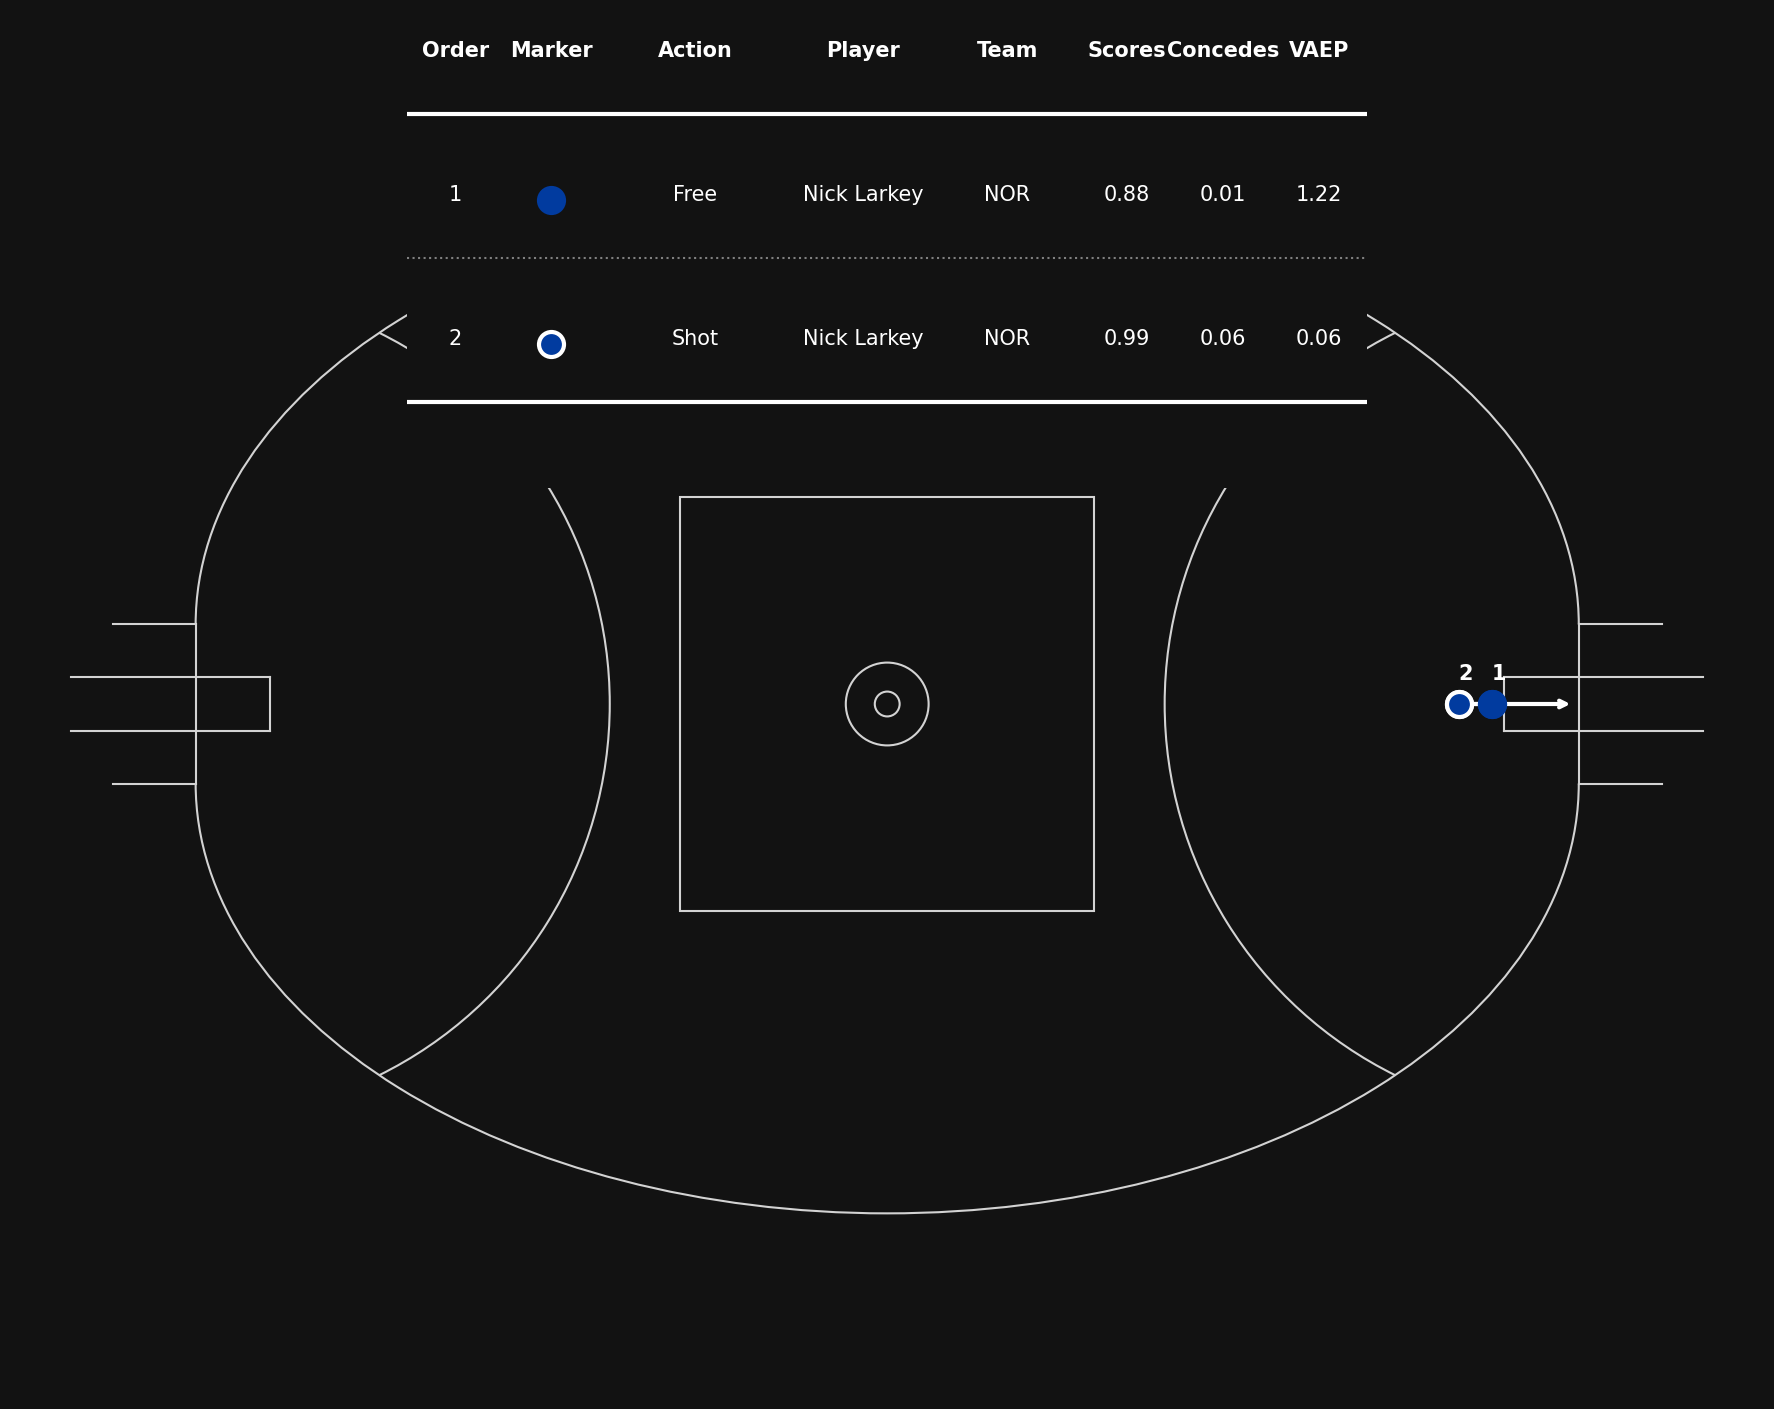

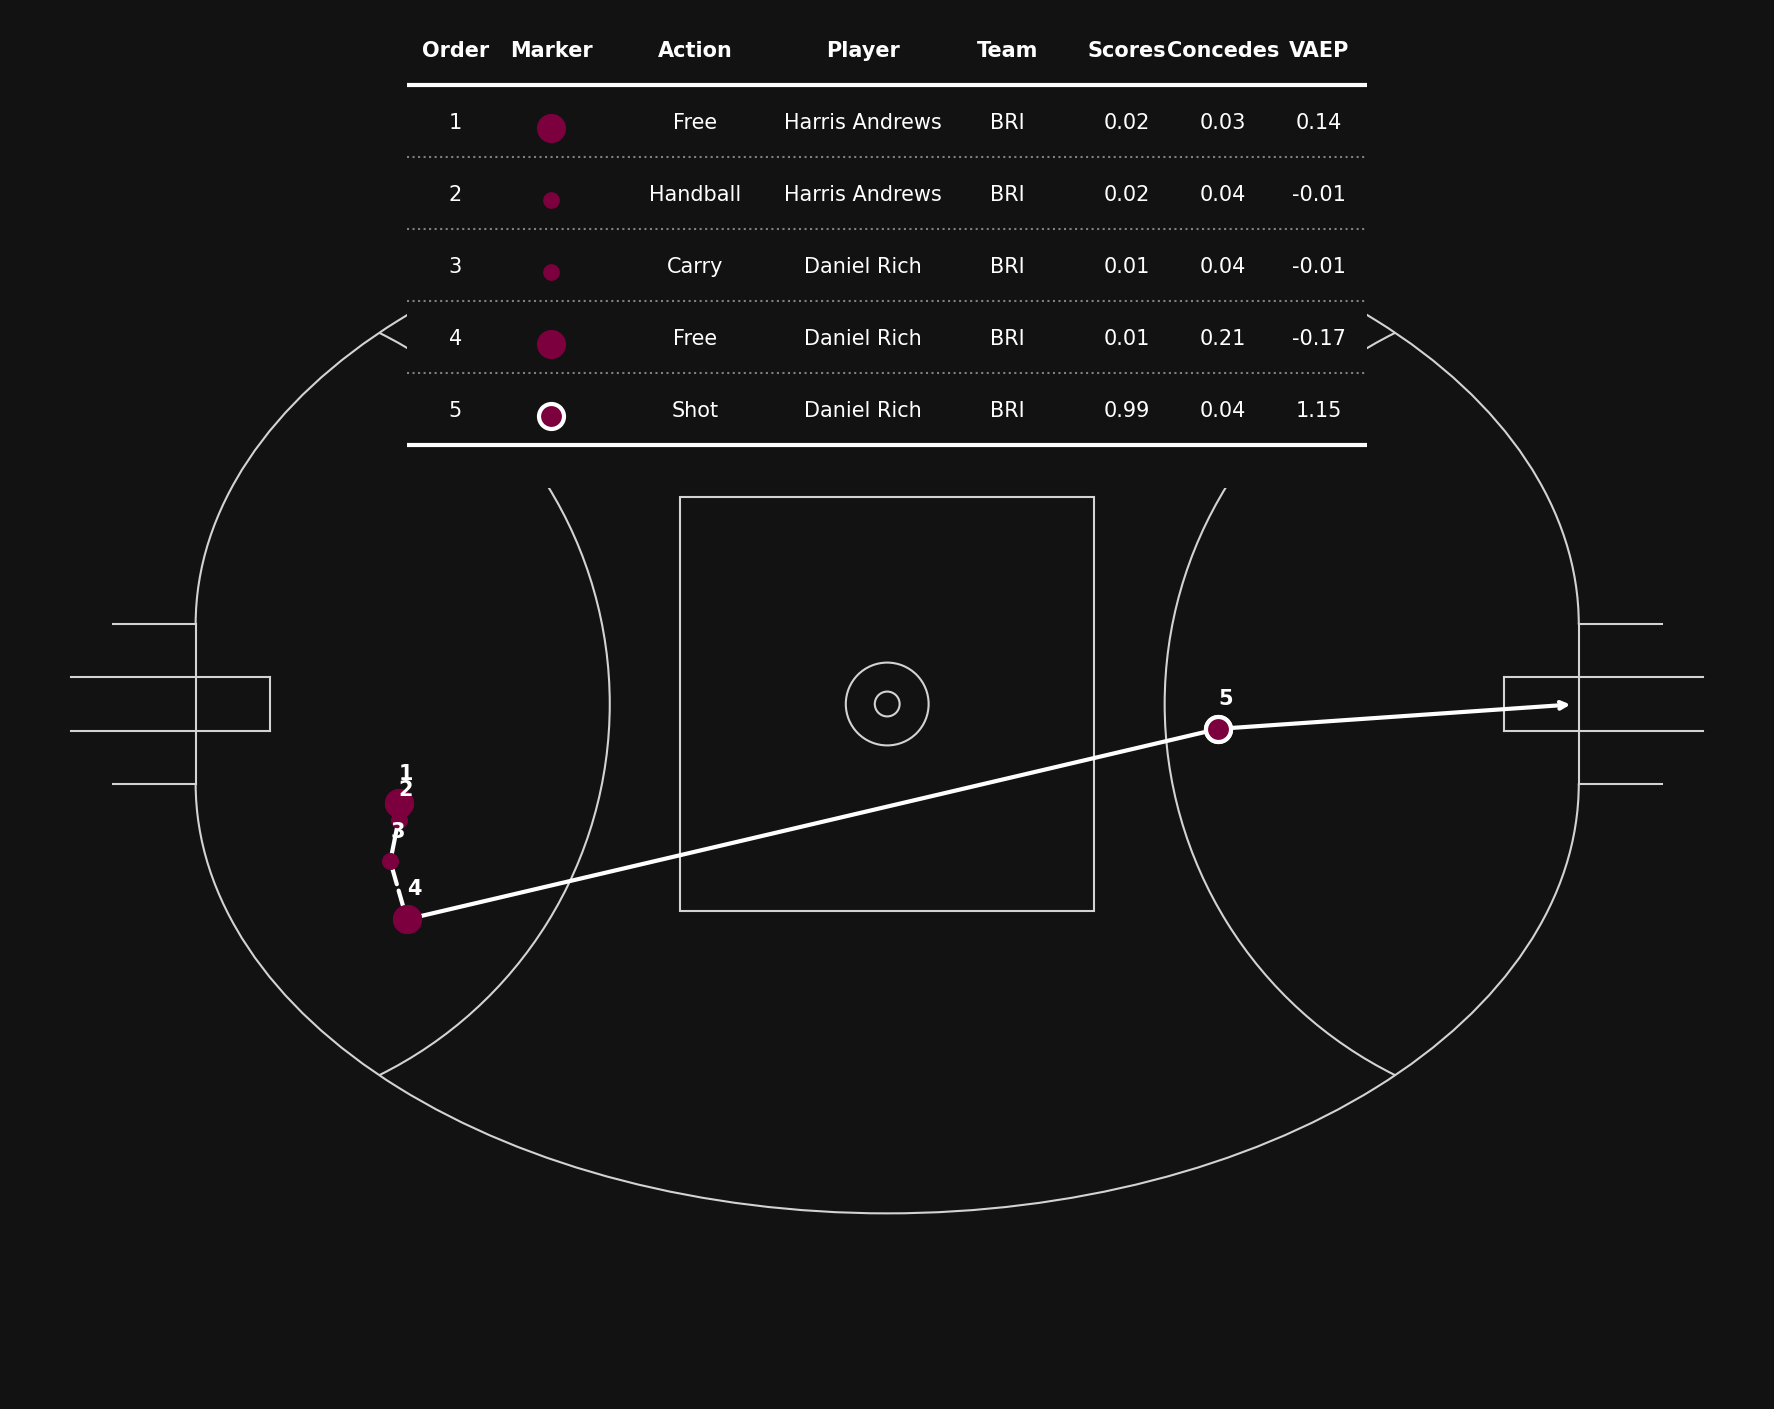

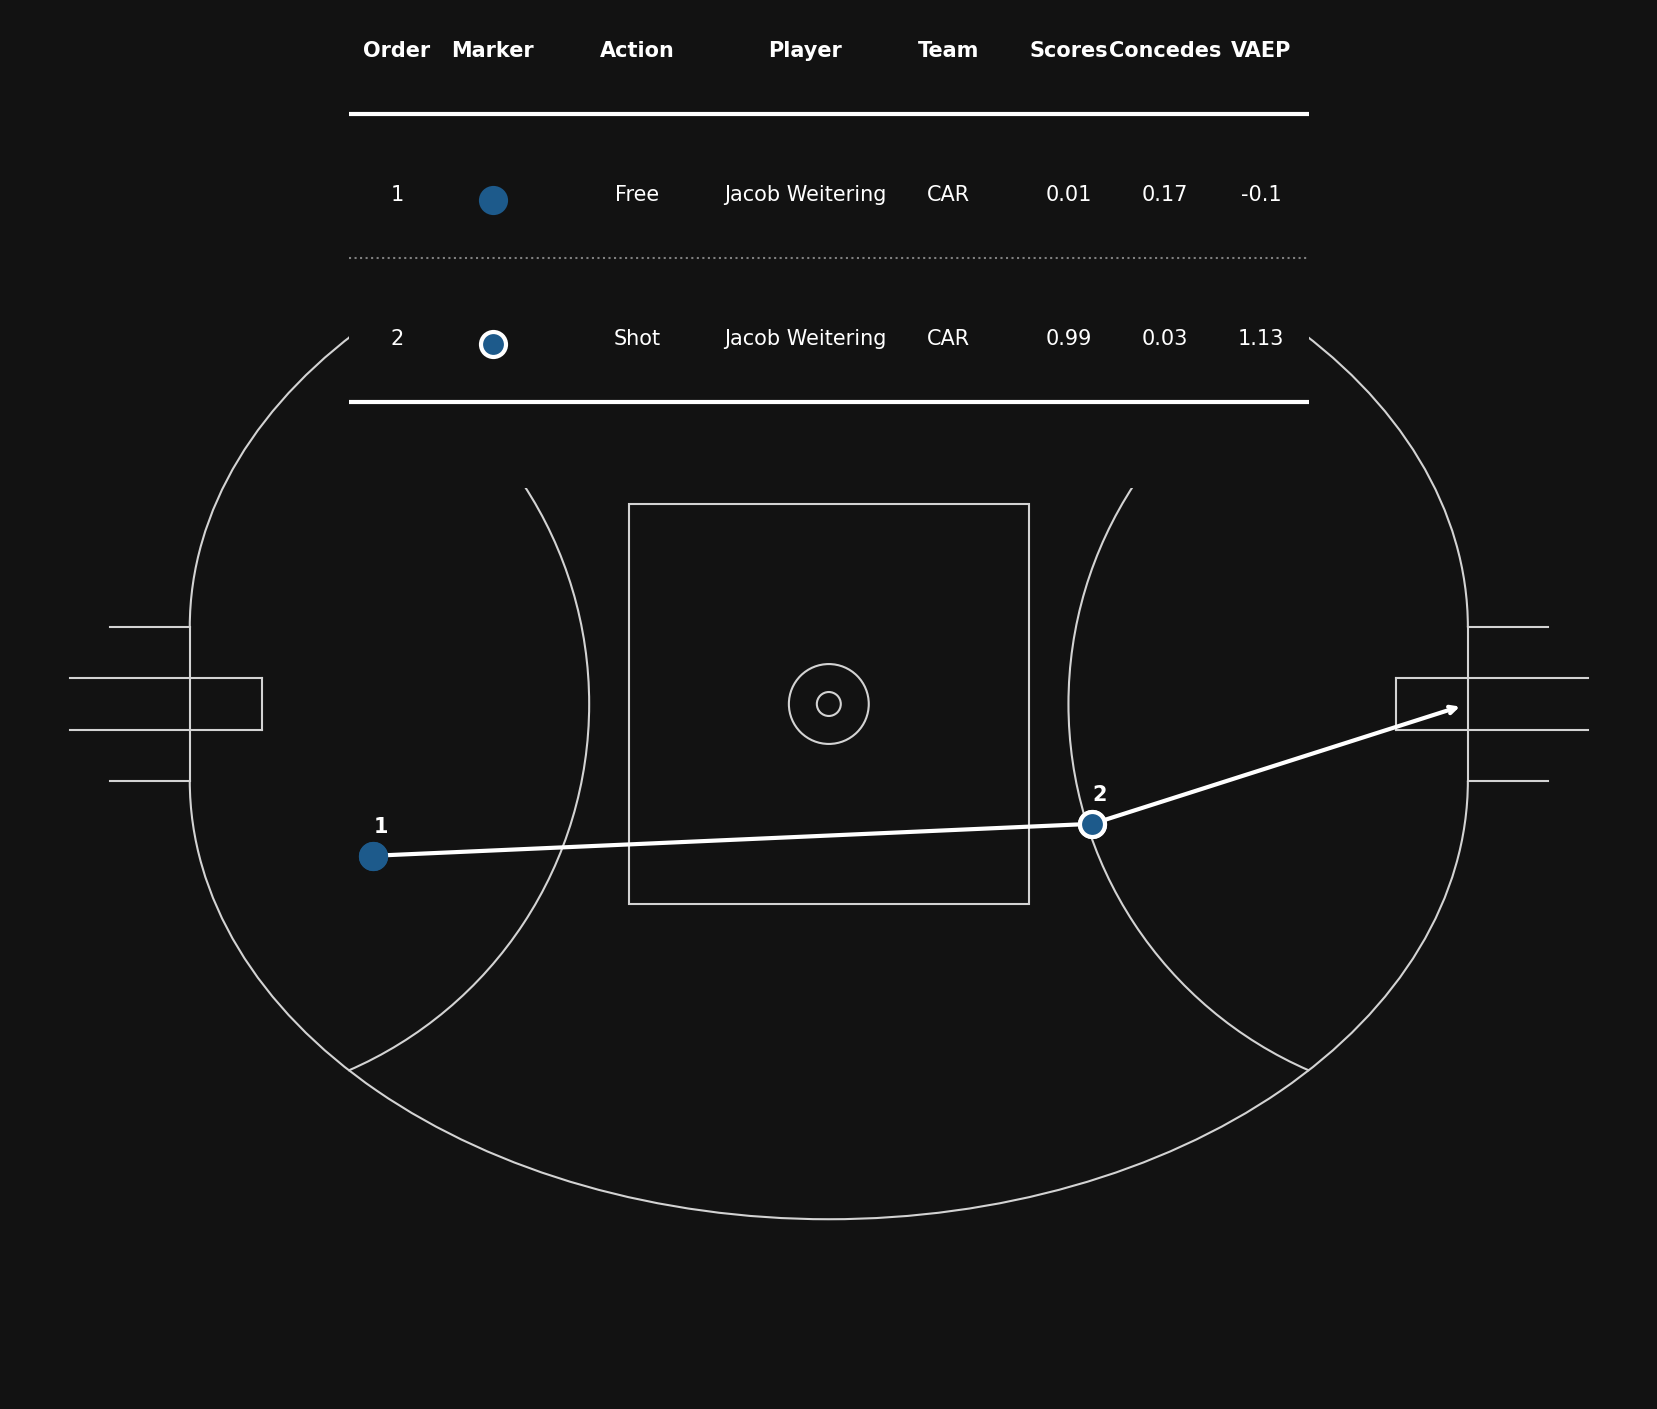

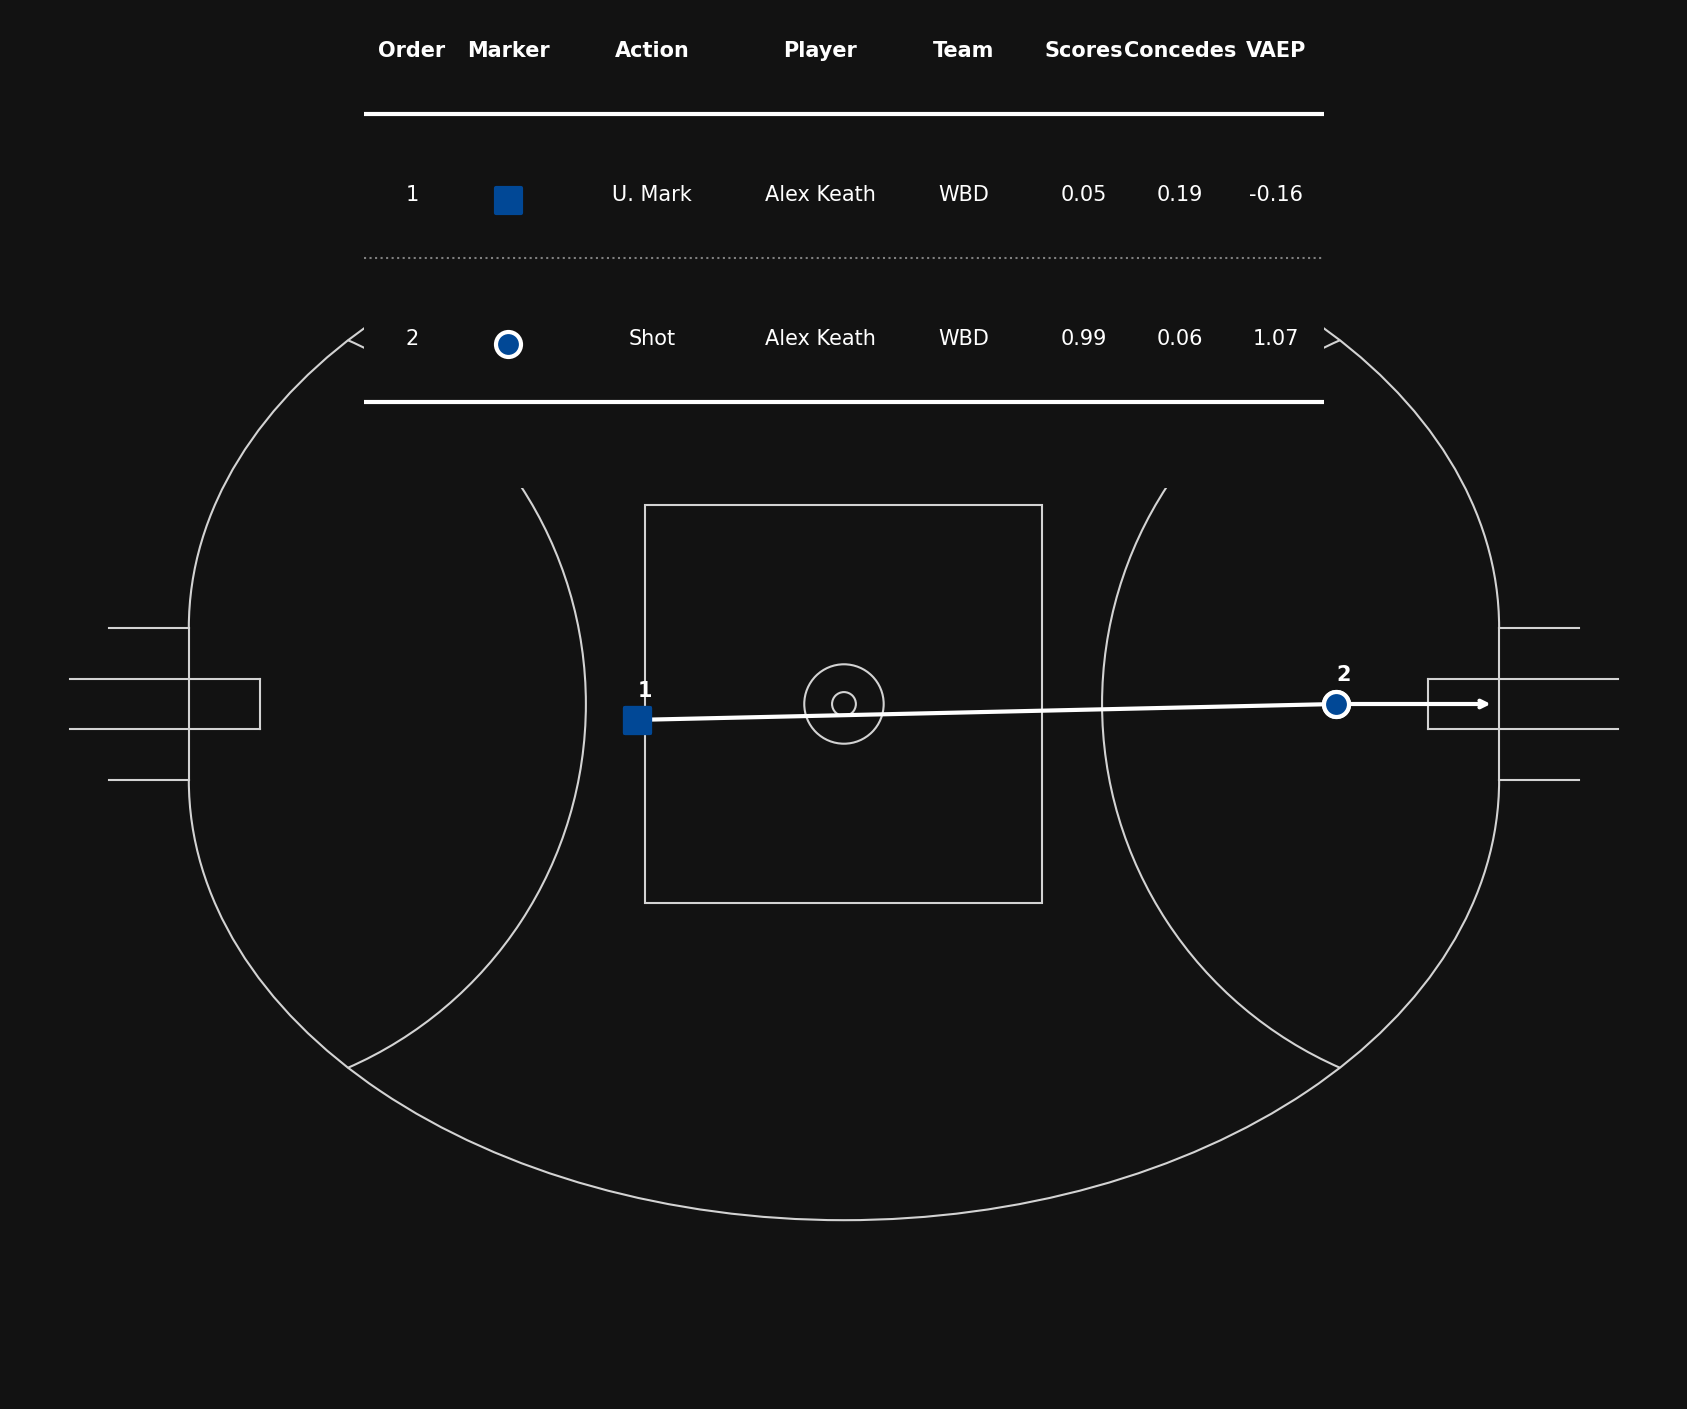

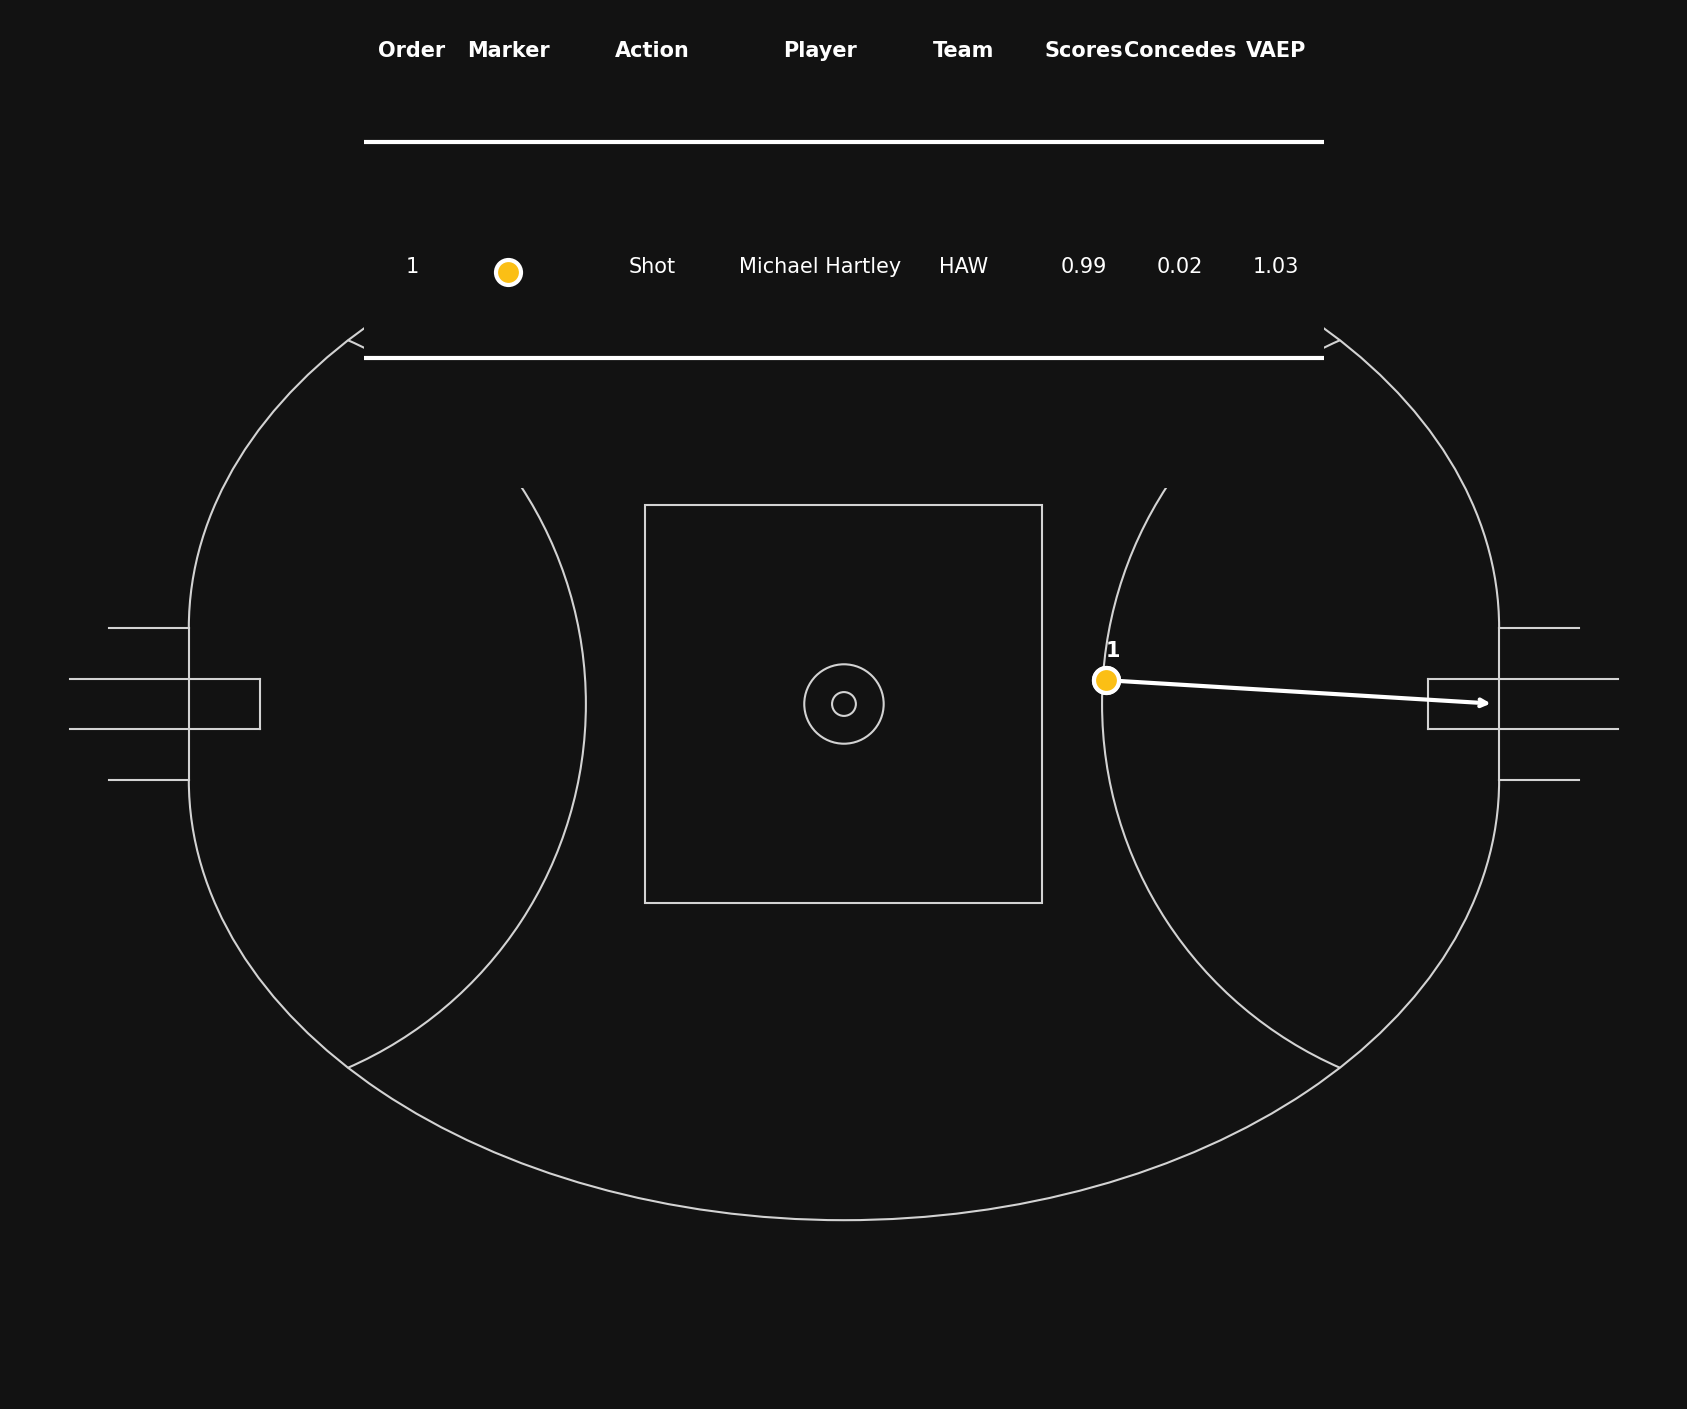

In [18]:
top_vaep_actions = chain_data.sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

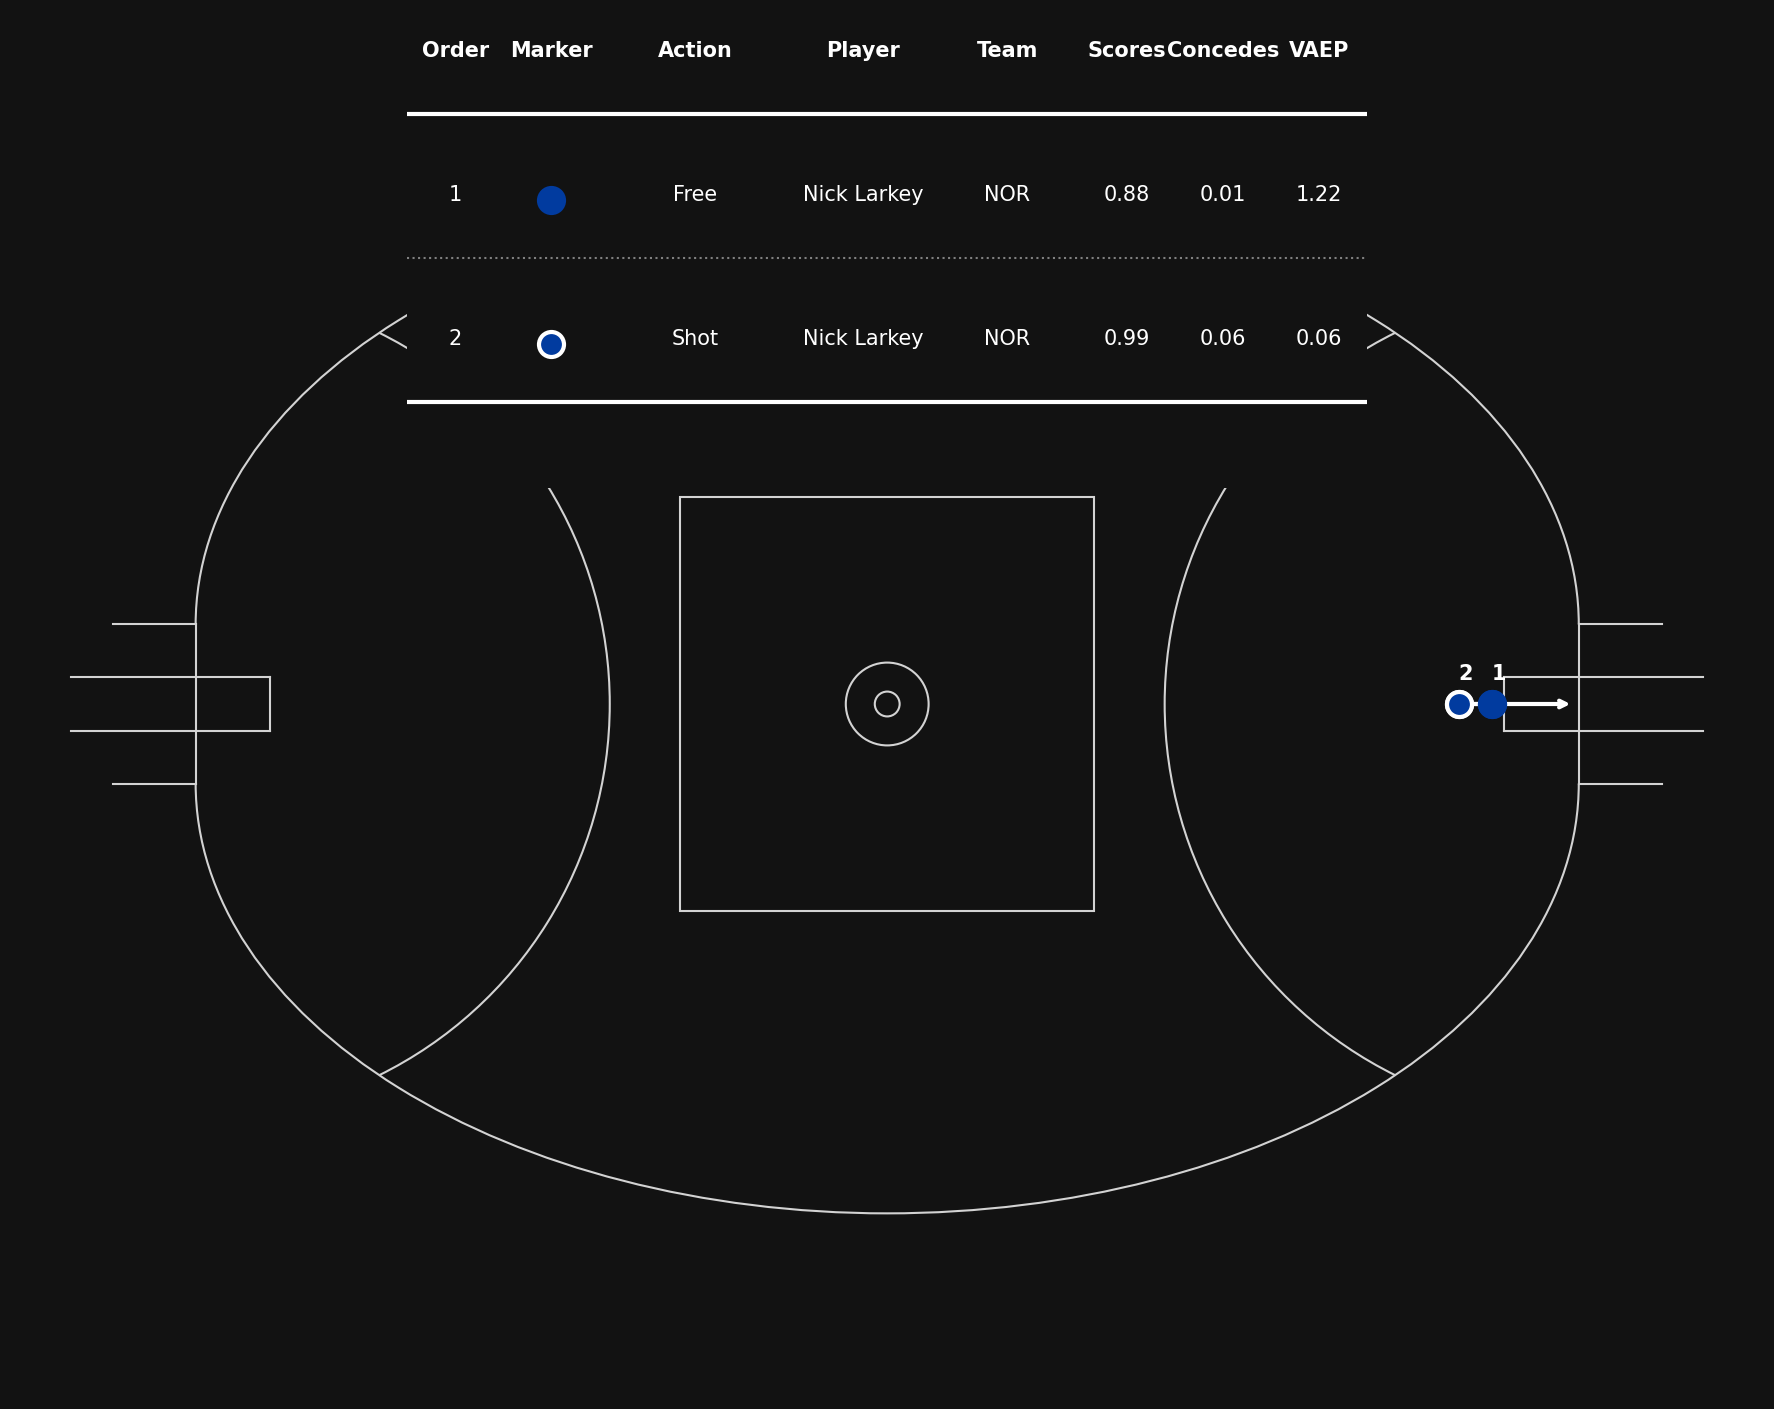

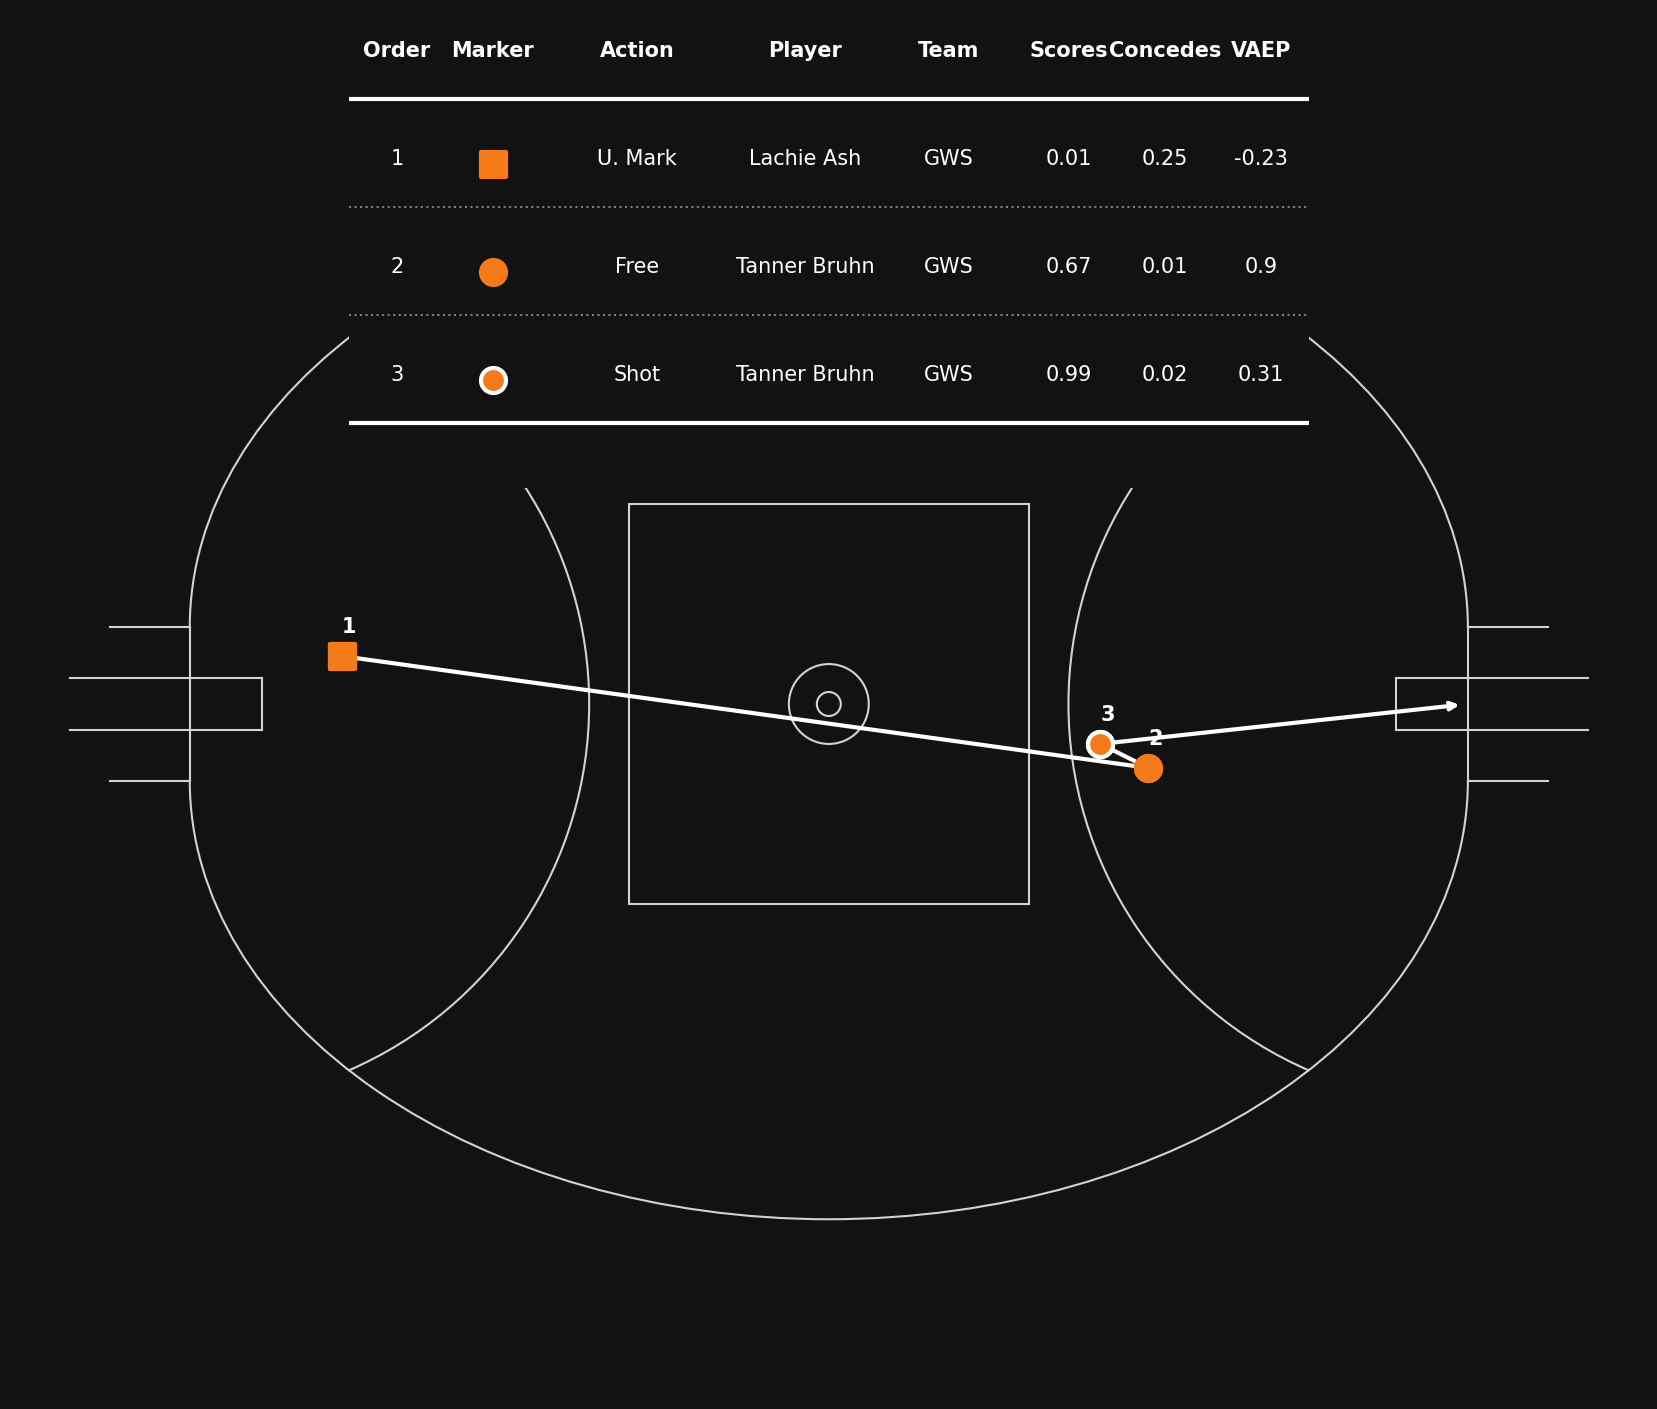

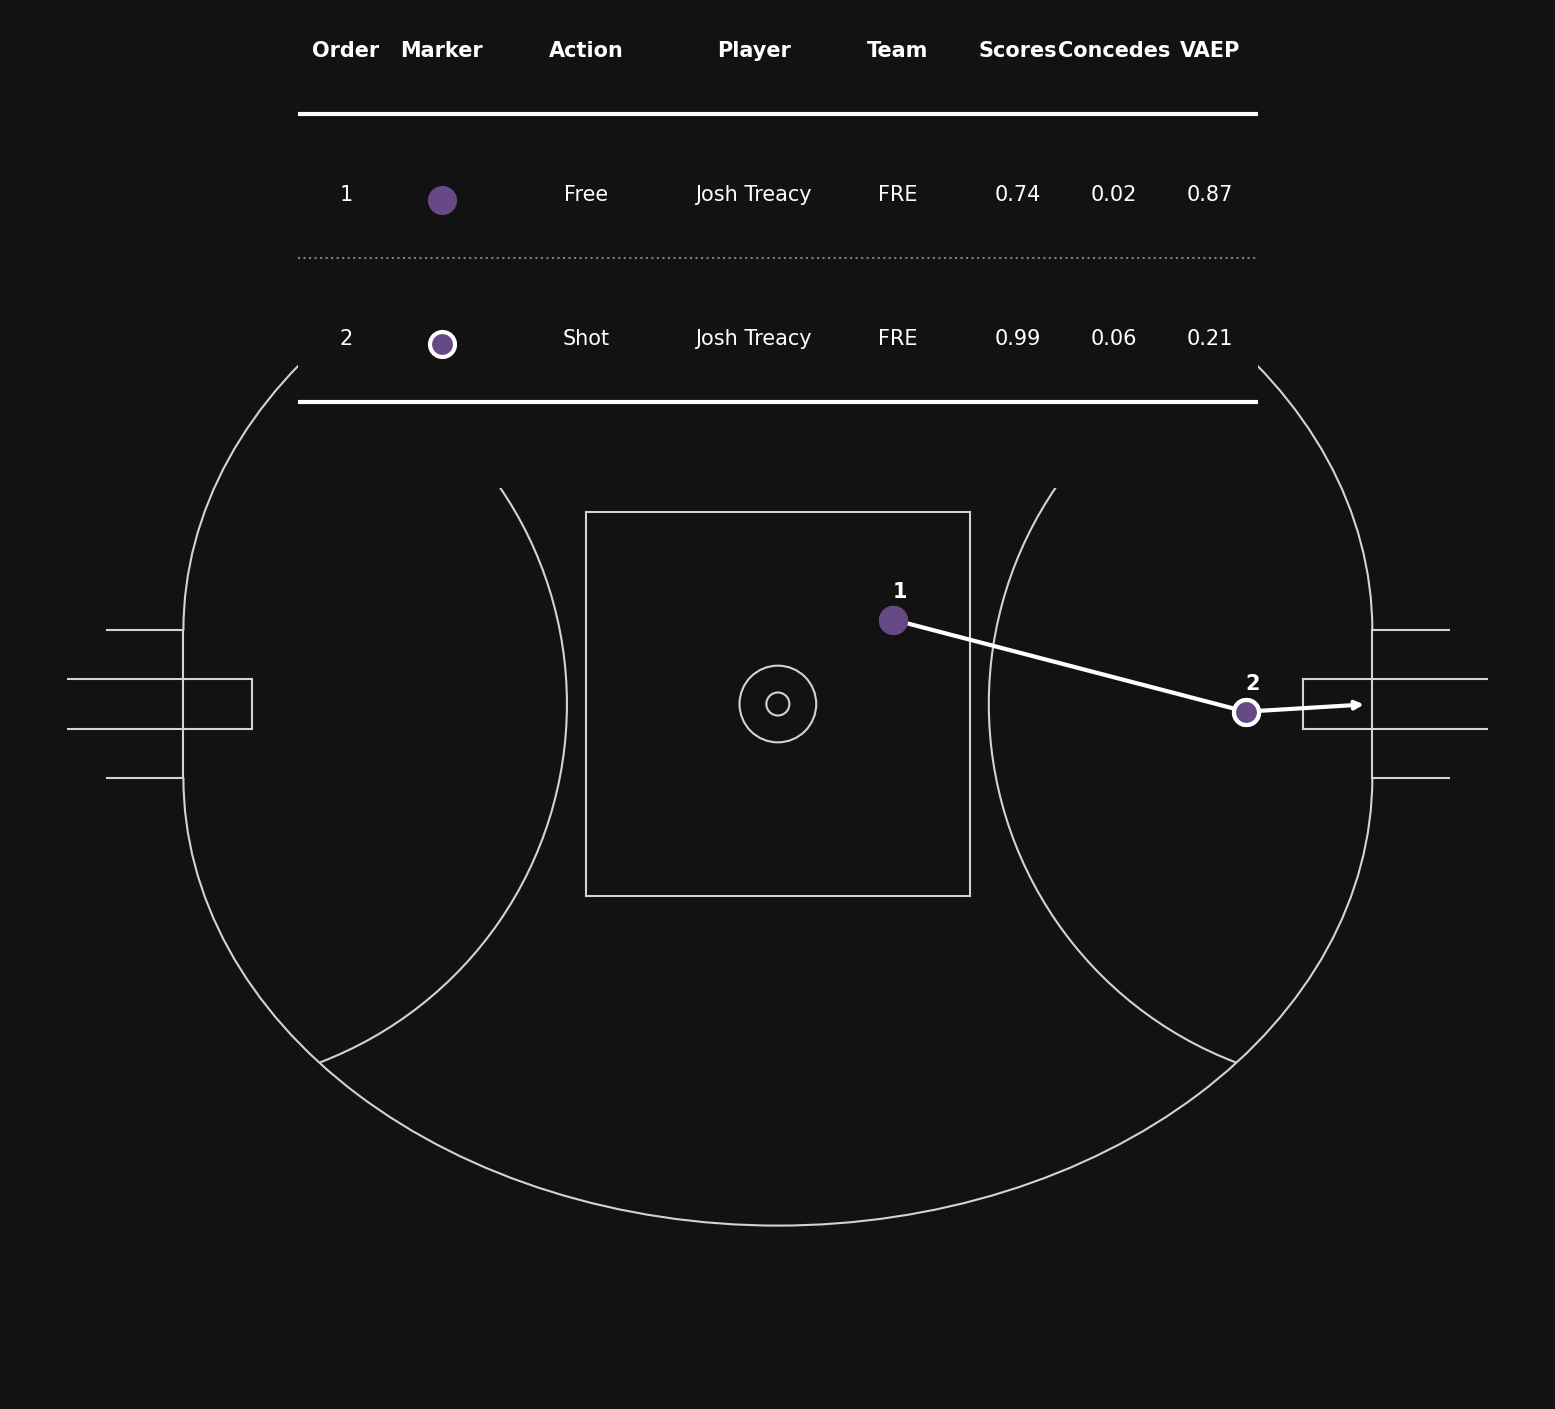

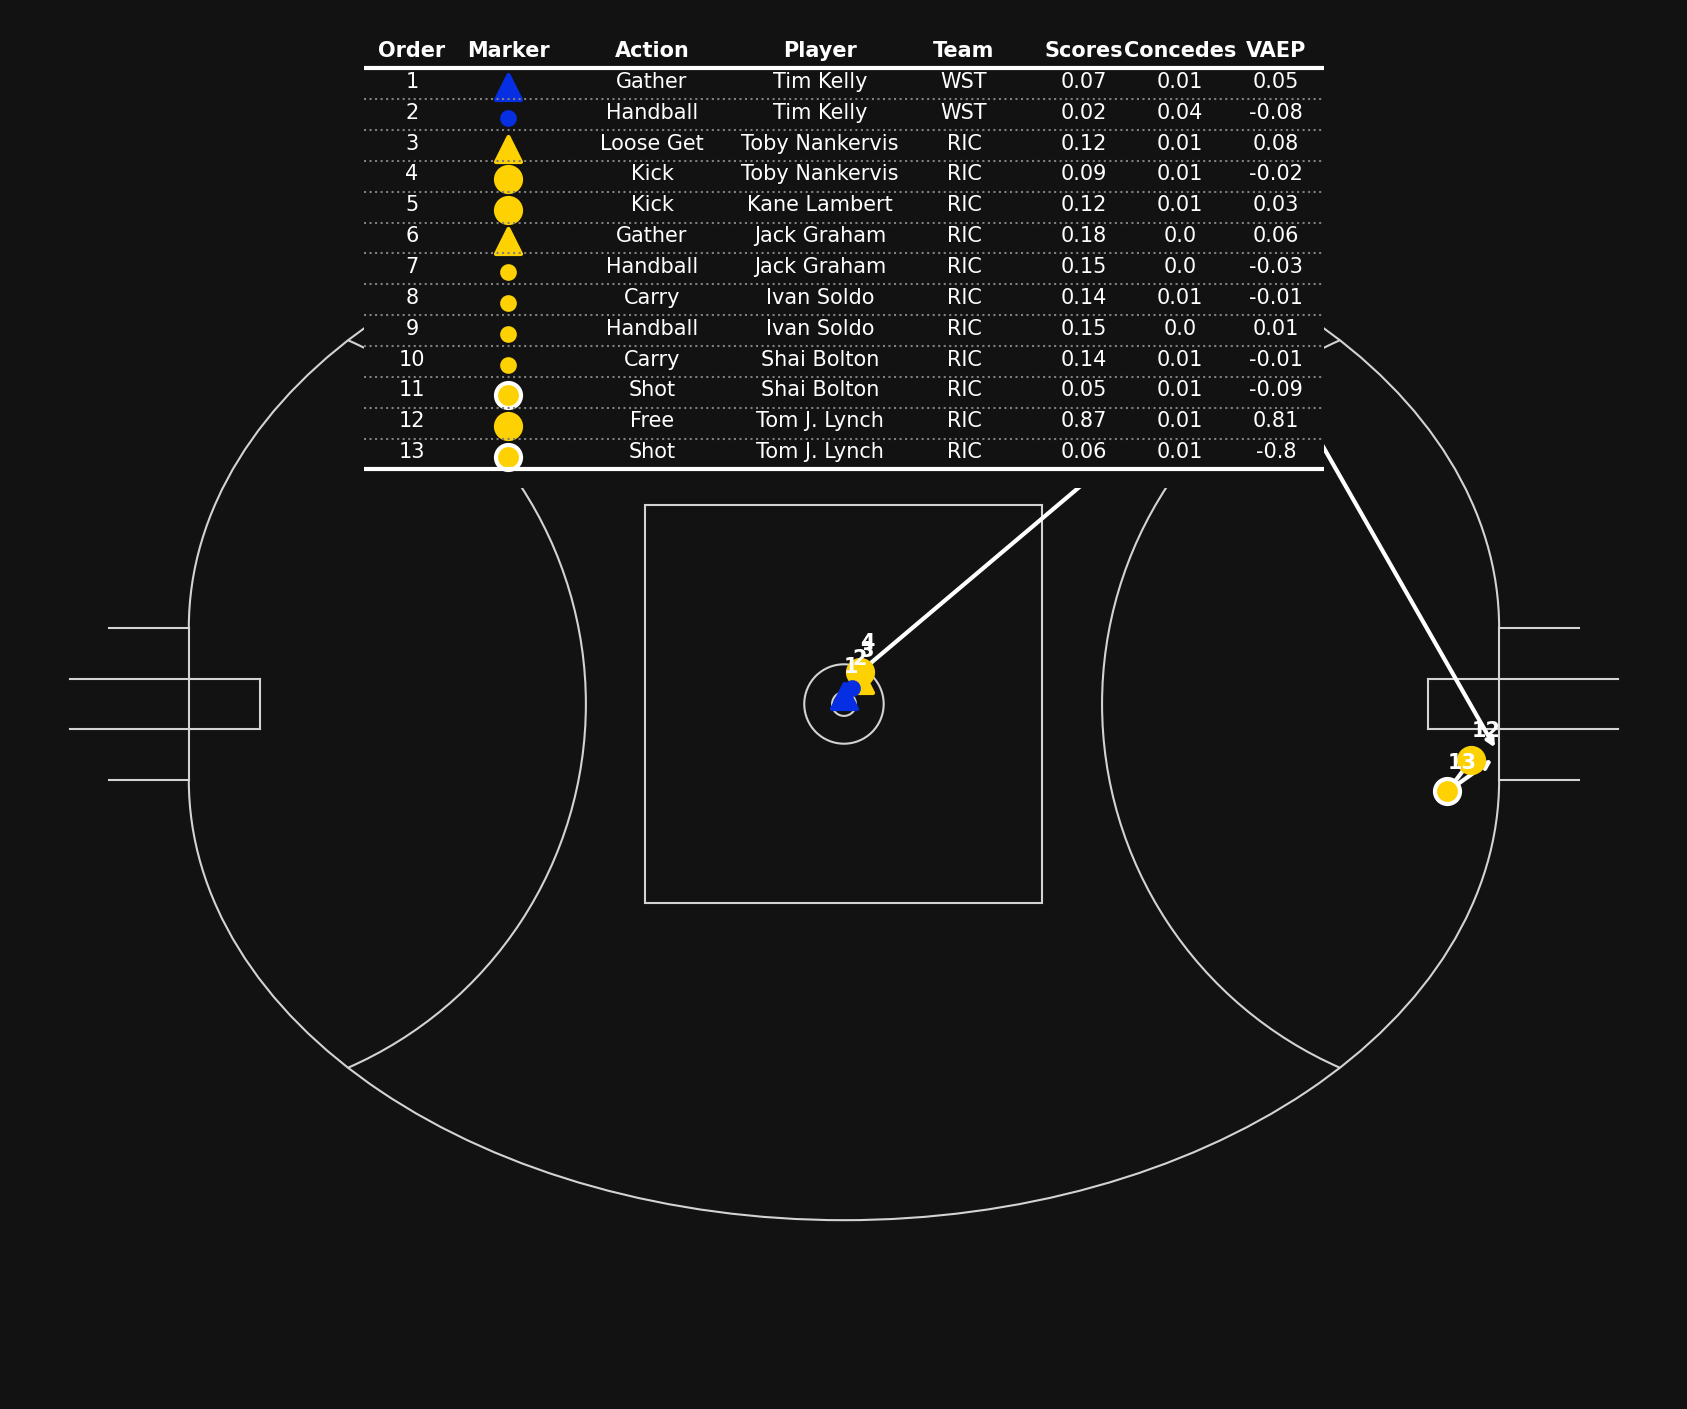

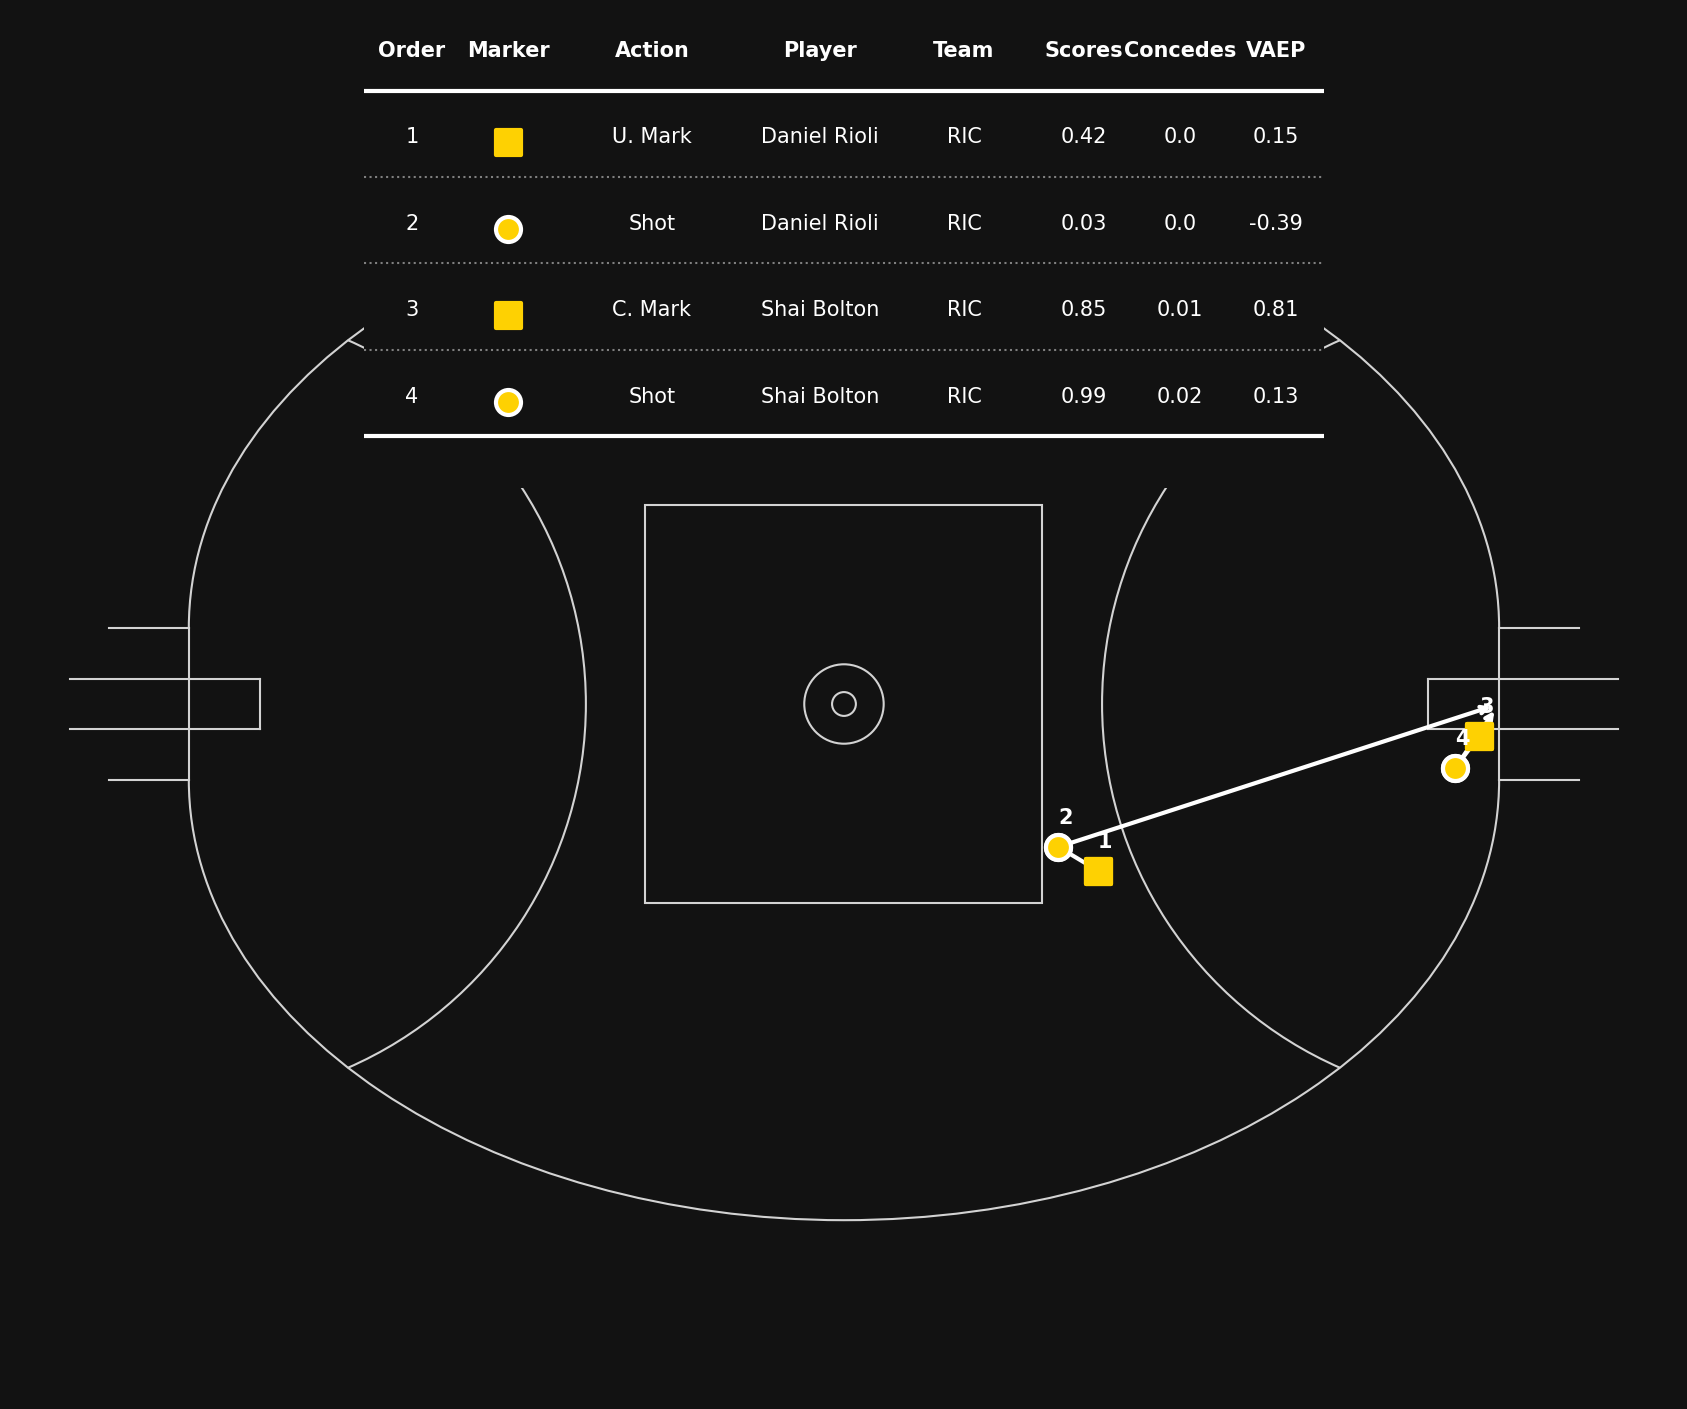

In [14]:
top_vaep_nonshot_actions = chain_data[~(chain_data['action_type'] == "Shot")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_nonshot_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_nonshot_actions['chain_number'])
for index in range(0, 5):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

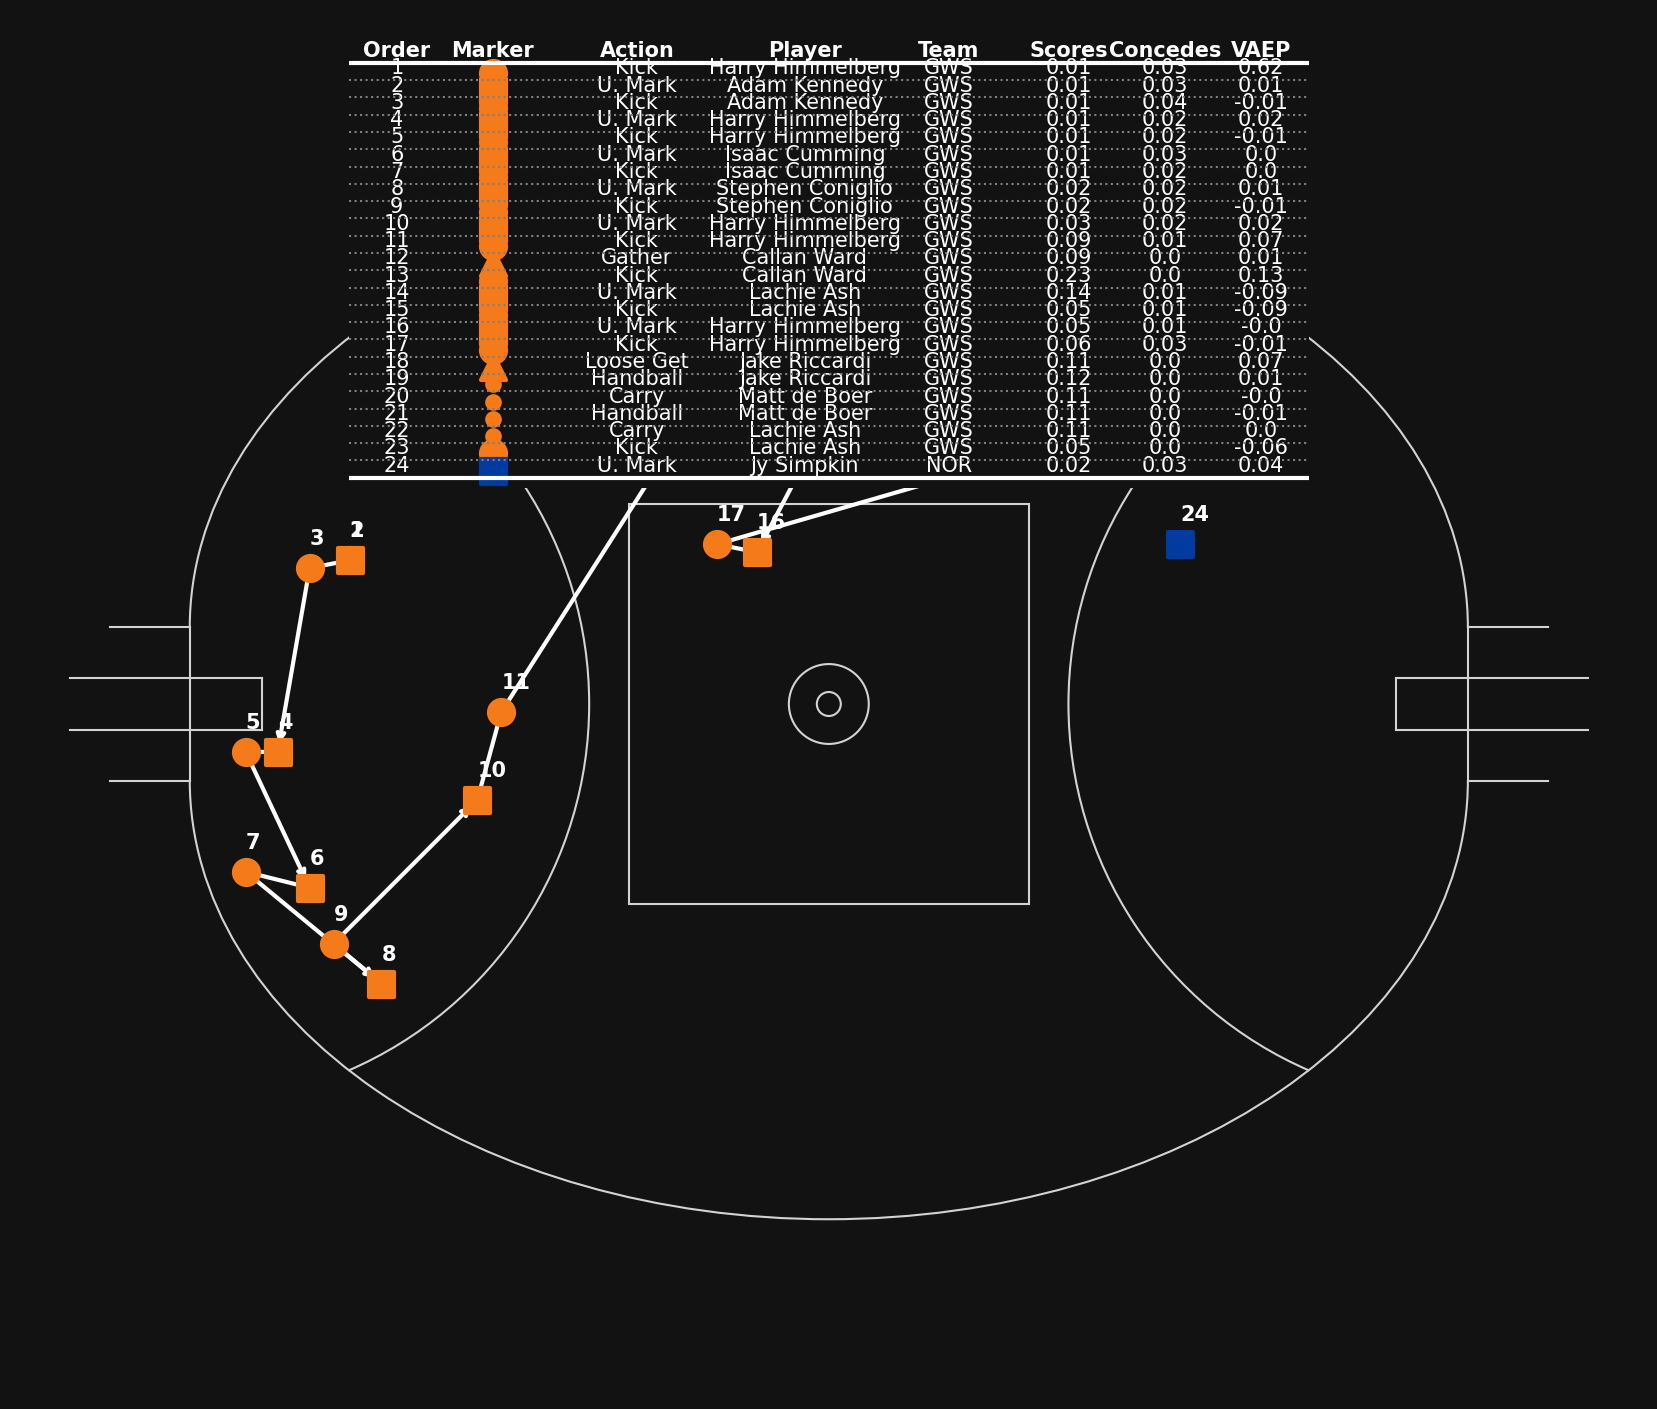

In [15]:
top_vaep_kick_actions = chain_data[(chain_data['action_type'] == "Kick")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_kick_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_kick_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

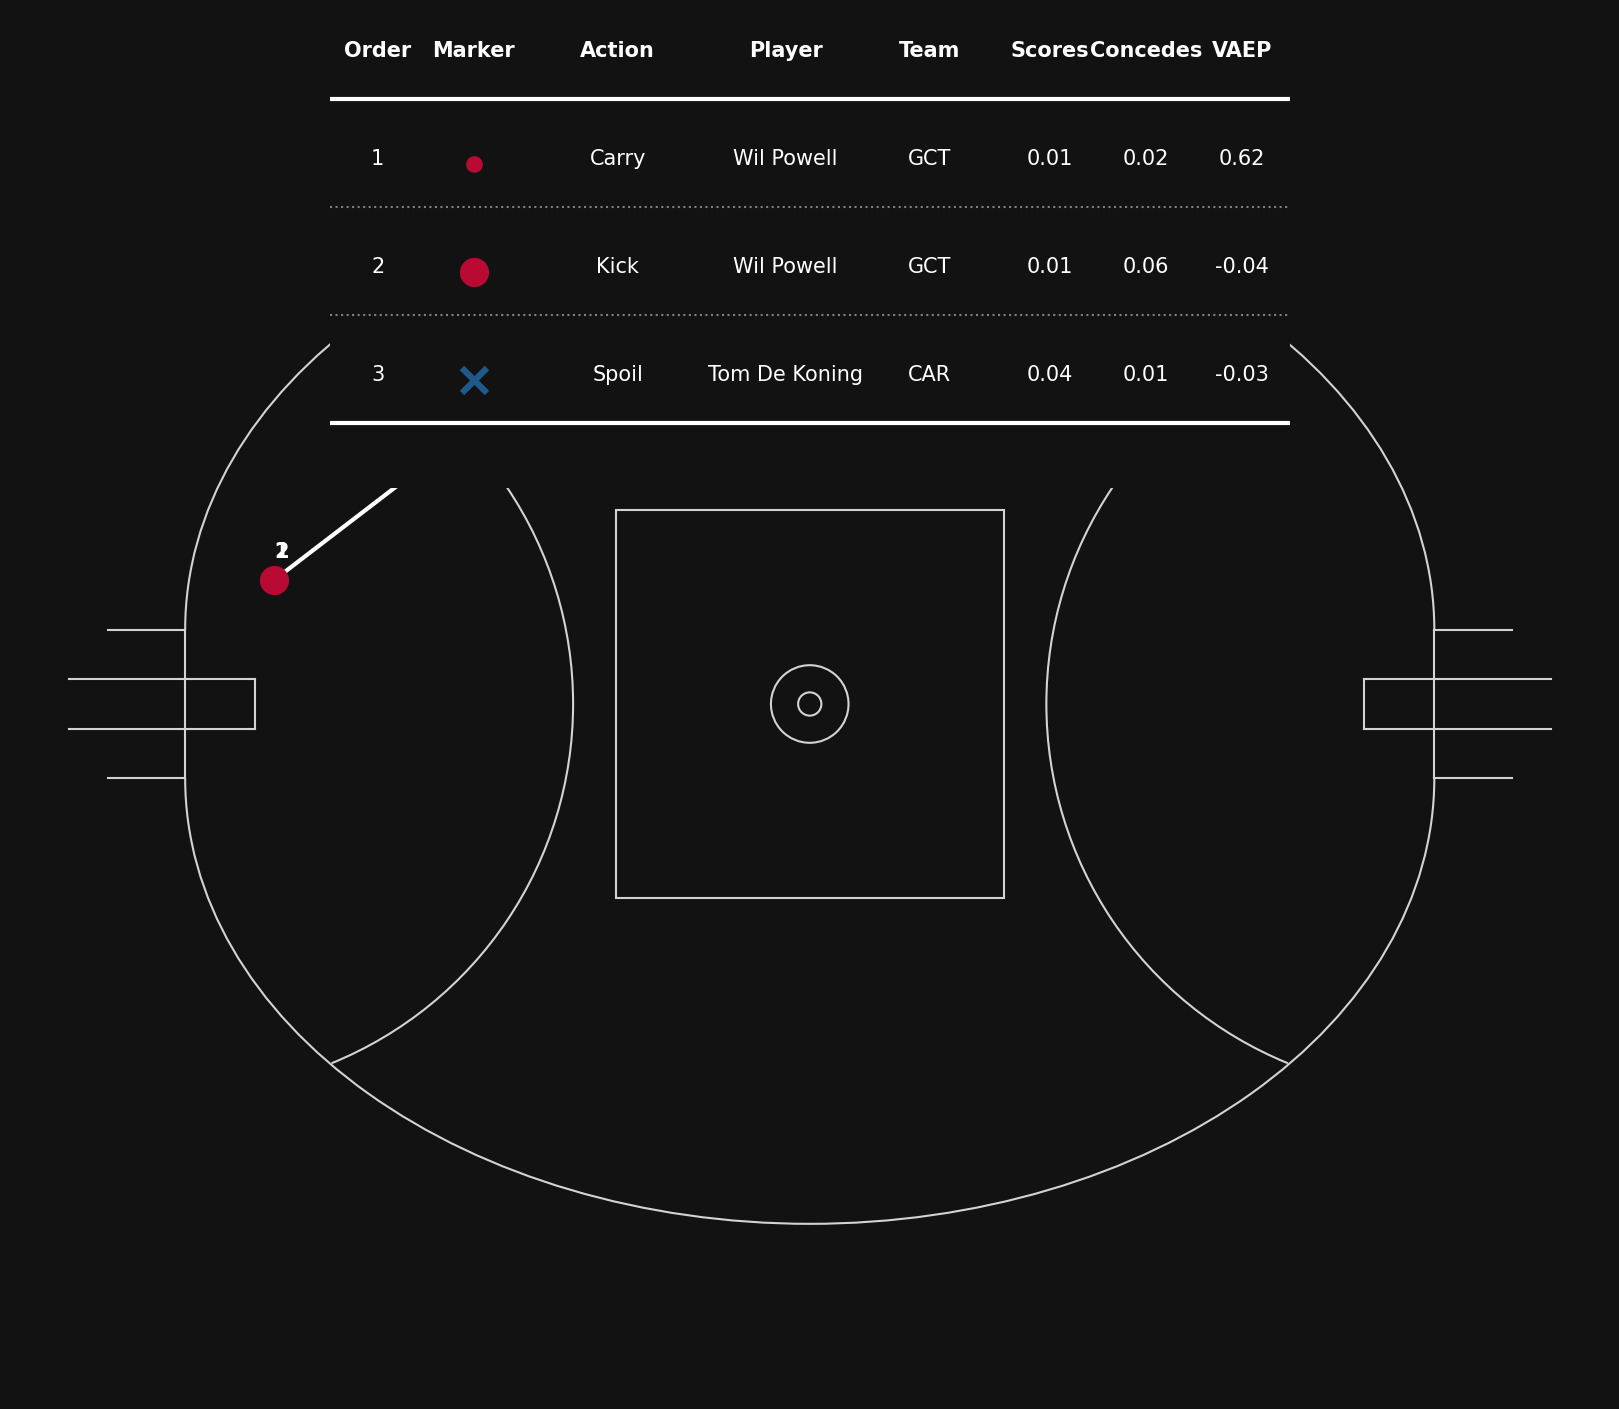

In [16]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Carry")].sort_values('vaep_value', ascending = False).head(5)
top_vaep_matches = list(top_vaep_carry_actions['match_id'])
top_vaep_chain_numbers = list(top_vaep_carry_actions['chain_number'])
for index in range(0, 1):
    match_id = top_vaep_matches[index]
    chain_number = top_vaep_chain_numbers[index]
    chain = get_chain(chain_data, match_id, chain_number)
    pitch_length, pitch_width = get_venue_dimensions(chain, match_id)
    
    pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
    fig, ax = pitch.draw()
    ax = plot_chain_vaep(chain, pitch, ax=ax)
    ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

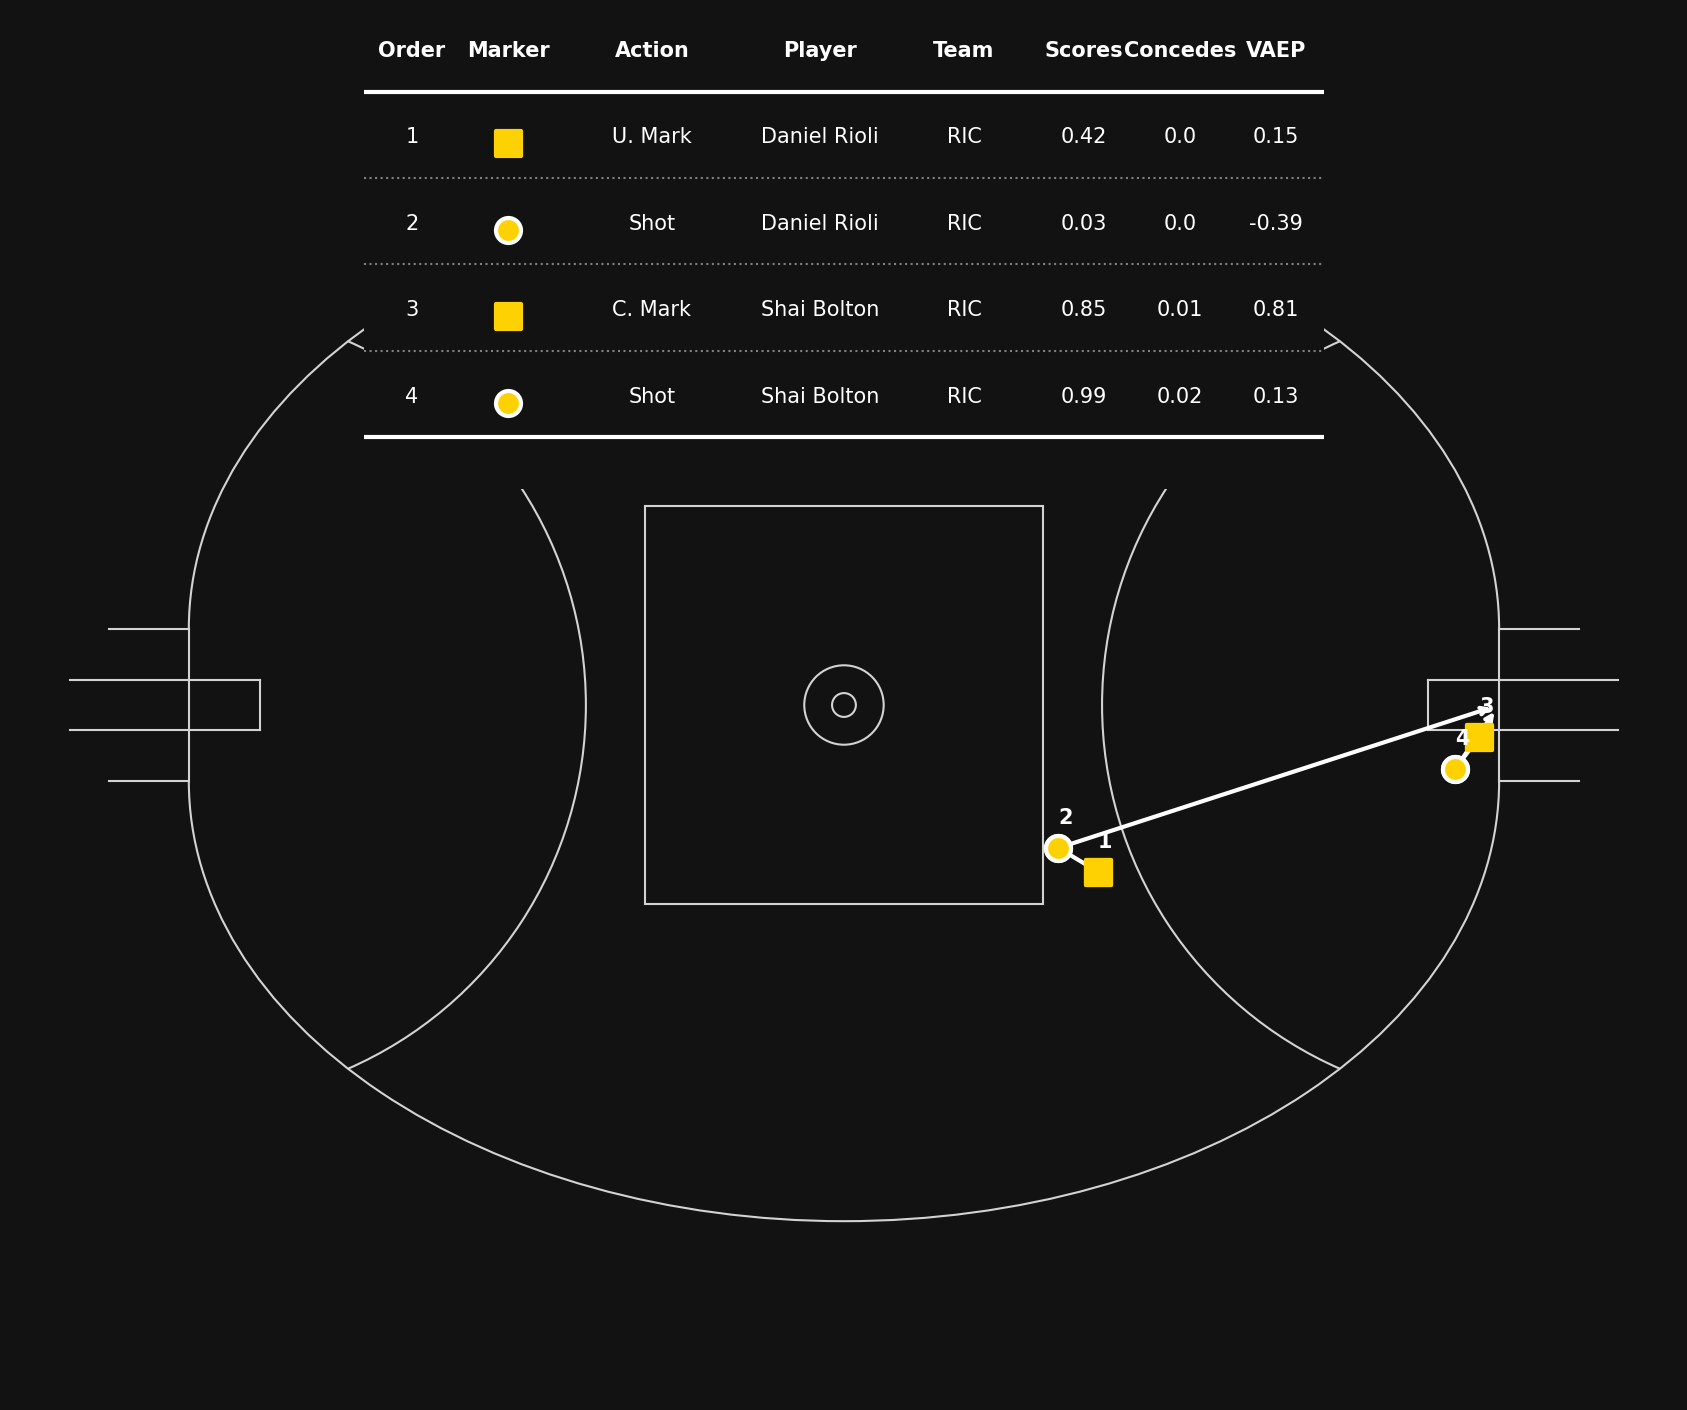

In [17]:
top_vaep_carry_actions = chain_data[(chain_data['action_type'] == "Contested Mark")].sort_values('vaep_value', ascending = False).head(1)
match_id = top_vaep_carry_actions['Match_ID'].iloc[0]
chain_number = top_vaep_carry_actions['Chain_Number'].iloc[0]
chain = get_chain(chain_data, match_id, chain_number)
pitch_length, pitch_width = get_venue_dimensions(chain, match_id)

pitch = Pitch(pitch_width=pitch_width, pitch_length=pitch_length, line_width = 0.5)
fig, ax = pitch.draw()
ax = plot_chain_vaep(chain, pitch, ax=ax)
ax_table = add_chain_table_vaep(chain, fig, left=0.25, bottom=0.65, width=0.5, height=0.3)

plt.savefig(
	"../figures/20230814_vaep_chain.png",
	dpi = 300,
	facecolor = "#121212",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)